# Models

In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels as sms

import numpy as np
from scipy.stats import norm, truncnorm
from scipy.stats import beta

from tqdm.notebook import tqdm


class NormativePerceptual:
    def __init__(self, *args, **kwargs):
        # super().__init__(*args, **kwargs)
        # slope prior
        self.slope_prior = kwargs.get('slope_prior', 2)
        # leak parameter
        self.leak = kwargs.get('leak', 0)
        # x values = forcefield values
        self.x = kwargs.get('x', np.linspace(-1, 1, 12))

        if not isinstance(self.x, np.ndarray):
            self.x = np.array(list(self.x))

        # possible values for the slope
        self.slope_range = kwargs.get(
            'slope_range', np.arange(-10, 10, 0.002))

        # initialize logposterior for the slope to prior
        self.lp_slope = np.log(norm.pdf(self.slope_range, 0, self.slope_prior))

        # define logit function
        self.logit = lambda x: 1 / (1+np.exp(x))

    def perceptual_update(self, choice, destroyed):
        v = self.slope_range*choice; v = v - v * 2 * destroyed # switch to negative if ff destroyed
        # compute log likelihood
        ll = np.log(self.logit(v))
        # update log posterior
        self.lp_slope += ll
        self._apply_leak_perceptual()

    def predictff(self, ff1=None, ff2=None):
        if ff1 is None and ff2 is None:
            # predict p(destroy) for all forcefields
            to_select = np.arange(len(self.x))
        else:
            # predict p(destroy) for 2 (displayed) forcefields
            x = np.arange(len(self.x))
            to_select = np.array([x[self.x == ff1][0], x[self.x == ff2][0]])

        return self.logit(-self.get_slope()*self.x[to_select])

    def get_slope(self):
        w = np.exp(self.lp_slope-np.max(self.lp_slope))
        slope = np.sum(w*self.slope_range)/np.sum(w)
        return slope
    #

    def _apply_leak_perceptual(self):
        self.lp_slope *= 1-self.leak


class NormativeValue:
    def __init__(self, *args, **kwargs):
        # super().__init__(*args, **kwargs)
        self.delta_prior = kwargs.get('delta_prior', .2)
        self.std_prior = kwargs.get('std_prior', .2)
        self.leak = kwargs.get('leak', 0)
        self.nstate = kwargs.get('nstate', 2)

        # possible values for the difference between two options
        self.delta_range = kwargs.get('delta_range', np.arange(-1, 1, 0.002))

        # initialize logposterior for the slope to prior
        self.lp_delta = [
            np.log(tnormpdf(0.5*(1+self.delta_range), 0.5, self.delta_prior))
            for _ in range(self.nstate)
        ]

    def value_update(self, s, a, r):
        v = 1-self.delta_range if a else 1+self.delta_range
        # compute log likelihood
        ll = np.log(tnormpdf(r, 0.5*(v), self.std_prior))
        # update log posterior
        self.lp_delta[s] += ll
        self._apply_leak_value(s)

    def get_delta(self, s):
        w = np.exp(self.lp_delta[s]-np.max(self.lp_delta[s]))
        delta = np.sum(w*self.delta_range)/np.sum(w)
        return delta

    def _apply_leak_value(self, s):
        self.lp_delta[s] *= 1-self.leak


class Normative(NormativeValue, NormativePerceptual):
    def __init__(self, *args, **kwargs):
        NormativeValue.__init__(self, *args, **kwargs)
        NormativePerceptual.__init__(self, *args, **kwargs)

        self.temp = kwargs.get('temp', 1e6)

    def make_choice(self, s, ff1, ff2):
        # default is EV decision
        p = self.predictff(ff1, ff2) if ff1 is not None else 1
        ev1, ev2 = (
            (.5 * (1+self.get_delta(s)*(np.array([1, -1])))) * p)
        choice = np.random.random() > 1/(1+np.exp(-self.temp*(ev1-ev2)))
        return choice

    def learn_perceptual(self, a, r):
        self.perceptual_update(a, r)

    def learn_value(self, s, a, r):
        self.value_update(s, a, r)

    def get_params(self, s=None):
        return {
            # beta logit (utf8 character symbol as key)
            'β': self.get_slope(),
            # delta (diff between two options) (utf8 character symbol as key)
            '$\delta$': self.get_delta(s) if s is not None
            else [self.get_delta(s) for s in range(self.nstate)],
        }


class NormativeEV(Normative,
                  NormativeValue, NormativePerceptual):
    def ll_of_choice(self, ff1, ff2, s, a):
        p1 = self.predictff(ff1, ff2) if ff1 is not None else 1
        ev1, ev2 = (
            (.5 * (1+self.get_delta(s)*(np.array([1, -1])))) * p1)
        p1 = 1/(1+np.exp(-self.temp*(ev1-ev2)))
        p = [p1, 1-p1]
        if p[a] == 0:
            p[a] += 1e-8
        return p[a]


class NormativeLogRatio(Normative,
                        NormativeValue, NormativePerceptual):
    def __init__(self, *args, **kwargs):
        Normative.__init__(self, *args, **kwargs)
        self.perceptual_temp = kwargs.get('perceptual_temp', 1e6)
        self.rl_temp = kwargs.get('rl_temp', 1e6)

    def make_choice(self, s, ff1, ff2):
        p = np.log(self.predictff(ff1, ff2)) if ff1 is not None else np.array([1, 1])
        ev = np.log(
            (.5 * (1+self.get_delta(s)*(np.array([1, -1]))))
        )
        dv = ev[0] - ev[1]
        dp = p[0] - p[1]
        x = (
            np.array([dv, dp]) *
            np.array([self.rl_temp, self.perceptual_temp])
        ).sum()
        choice = int(np.random.random() > 1/(1+np.exp(-x)))
        return choice

    def ll_of_choice(self, ff1, ff2, s, a):
        p = np.log(self.predictff(ff1, ff2)) if ff1 is not None else 1
        ev = np.log(
            (.5 * (1+self.get_delta(s)*(np.array([1, -1]))))
        )
        dv = ev[0] - ev[1]
        dp = p[0] - p[1]
        x = (
            np.array([dv, dp]) *
            np.array([self.rl_temp, self.perceptual_temp])
        ).sum()
        p1 = 1/(1+np.exp(-x))
        p = [p1, 1-p1]
        if p[a] == 0:
            p[a] += 1e-8

        return p


class RandomModel:
    def __init__(self, *args, **kwargs):
        pass

    @staticmethod
    def make_choice(s, ff1, ff2):
        return np.random.choice(np.arange(2))

    @staticmethod
    def learn_perceptual(a, r):
        pass

    @staticmethod
    def learn_value(s, a, r):
        pass

    @staticmethod
    def get_params(s=None):
        pass


def tnormpdf(x, m, s):
    x = x + np.zeros_like(m)
    p = norm.pdf(x, m, s)
    cdf_range = norm.cdf(1, m, s) - norm.cdf(0, m, s)
    p = p / (s * cdf_range)
    return p


def tnormpdf2(x, loc, std, lb=0, ub=1):
    # TODO: check why it doesn't work
    a, b = (lb-loc)/std, (ub-loc)/std
    return truncnorm(a, b, loc=loc).pdf(x)


def tnormrdn(loc, std, lb=0, ub=1, size=1):
    a, b = (lb-loc)/std, (ub-loc)/std
    x = truncnorm(a, b, loc=loc, scale=std).rvs(size=size)
    return x[0] if len(x) == 1 else x


<>:127: SyntaxWarning: invalid escape sequence '\d'
<>:127: SyntaxWarning: invalid escape sequence '\d'
C:\Users\garciaba\AppData\Local\Temp\ipykernel_32500\3712574755.py:127: SyntaxWarning: invalid escape sequence '\d'
  '$\delta$': self.get_delta(s) if s is not None


# Fit behavior

In [5]:

x = [.8 , .7]

a = [0, 1]
t = 1
ll = 0
p1 = 1/(1+np.exp(x[1]-x[0]))
p2 = 1-p1

y1 = np.log([p1, p2][a[t]])
y2 = np.log(np.exp(x - logsumexp(x)))[a[t]]

y1, y2

NameError: name 'logsumexp' is not defined

In [6]:
import itertools
from scipy.special import logsumexp

def fit(x0, *args):
    # print('Running fit...')
    ntrials, s, a, r, destroy, ff1, ff2, ff_values = args
    try:
        _ = len(x0)
    except:
        x0 = [x0]
        
    if len(x0) == 1:
        temp = x0[0]
        m = NormativeEV(temp=temp, x=list(ff_values))
    else:
        perceptual_temp = x0[0]
        rl_temp = x0[1]
        m = NormativeLogRatio(nstate=len(np.unique(s)), perceptual_temp=perceptual_temp, rl_temp=rl_temp, x=list(ff_values))
    
    ll = 0

    for t in range(ntrials):
        
        if a[t] not in (0, 1):
            continue

        ff_chosen = [ff1[t], ff2[t]][a[t]]
        m.learn_perceptual(ff_chosen, destroy[t])

        if destroy[t]:
            m.learn_value(s[t], a[t], r[t])
        
        p_of_choices = m.ll_of_choice(ff1[t], ff2[t], s[t], a[t])
        ll += np.log(np.exp(p_of_choices - logsumexp(p_of_choices)))[a[t]]
        

    return -ll, m.get_params()

def fit_pwf(x0, *args):
    ntrials, s, a, r, destroy, ff1, ff2, ff_values = args
    logistic = lambda ff, x: 1/(1+np.exp(ff*-x))
    ll = 0

    for t in range(ntrials):
        ff = np.array([ff1[t], ff2[t]])

        # ll += np.log(logistic(ff_chosen, x0[0]))
        x = logistic(ff, x0[0]) * r[t]
        
        # p1 = 1/(1+np.exp(x[1]-x[0]))
        # p2 = 1-p1
        # ll += np.log([p1, p2][a[t]])

        ll += np.log(np.exp(x - logsumexp(x)))[a[t]]

    return (-ll, 0)


def minimize(f, space, args):
    array = np.zeros(len(space))
    params = []
    count = 0
    for x in space:
        array[count], param = f(x, *args)
        params.append(param)
        count += 1
    argmin = np.argmin(array)
    return (space[argmin], array[argmin],params[argmin], array)
        


    

In [ ]:
df.expName.str.contains('FullPilot')

111113    True
111120    True
111122    True
111127    True
111130    True
          ... 
177619    True
177621    True
177623    True
177625    True
177628    True
Name: expName, Length: 8858, dtype: bool

In [7]:

import seaborn as sns
# import sys
# sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('../data/raw/fullpilot13_2.csv')

# exclude participants  before 2024-02-22

# last batch
exp_mask = df.expName.str.contains('FullPilot12')
# change NaNs into False
exp_mask = exp_mask.fillna(False)
df = df[exp_mask]


# df = df[df.prolificID == 'basiletest']
# print shape[0] for each participant
df = df.groupby('prolificID').filter(lambda x: x.shape[0] >= 480)
# df = df.groupby('prolificID').filter(lambda x: x.shape[0] >= 300)
df = df[df.prolificID.str.len() > 10]
print(df.groupby('prolificID').size())

df = df[df.session.isin([3])]
df = df[df.choice.isin([1, 2])]
df = df[df.pair.isin([0,1])]

df['delta_ff'] = (df.p1 - df.p2).abs().round(2)
df['delta_ss'] = (df.m1 - df.m2).abs().round(2)
df['delta_ev'] = (df.ev1 - df.ev2).abs().round(2)
df['correct'] = (df.ev1 > df.ev2) & (df.choice == 1) | (df.ev2 > df.ev1) & (df.choice == 2)
df['opti_ff'] = (df.p1 > df.p2) & (df.choice == 1) | (df.p2 > df.p1) & (df.choice == 2)
df['opti_ss'] = (df.m1 > df.m2) & (df.choice == 1) | (df.m2 > df.m1) & (df.choice == 2)
df['outcome'] = (df.outcome1 * (df.choice == 1) * df.destroyed) + (df.outcome2 * (df.choice == 2) * df.destroyed)
df['outcome'] /= 1000
# fireTime is in ms, convert to seconds
df['fireTime'] = df.fireTime / 1000
# df['trial'] = ((df.t.max()+1) * (df.session-2)) + df.t
df['trial'] = df.t

print('Number of participants:', df.prolificID.nunique())
map_prolificID = {pid: i for i, pid in enumerate(df.prolificID.unique())}
df['id'] = df.prolificID.map(map_prolificID)

df['pair'] = df.pair.apply(lambda x: 0 if x < 0 else x)

# define probabilities
x = np.linspace(-1, 1, 9)
pp = (1/(1+np.exp(-2*x))).round(2)

print(pp)
    # break



prolificID
5484d361fdf99b0379939d5b    488
58c42d725866f200017c5deb    563
5a580fb6eedc320001426cd7    488
5a9353586219a30001d2f2af    488
5a9416ba6475f900019fa690    488
                           ... 
66f09b3690fe3df51613a689    488
66f6c4195f17d26ce8c8018d    488
66f7102d3196ce5e60b2c1bd    488
66fc60b6f59bcb7d6dba7d4f    488
66ffb576e0cde42ca9ea7fa7    488
Length: 61, dtype: int64
Number of participants: 61
[0.12 0.18 0.27 0.38 0.5  0.62 0.73 0.82 0.88]


# Parameter Retrieval

In [ ]:
#remove duplicated trials
df = df.drop_duplicates(subset=['prolificID', 'session', 't'])
df.groupby('prolificID').size()

prolificID
5484d361fdf99b0379939d5b    144
58c42d725866f200017c5deb    144
5a580fb6eedc320001426cd7    143
5a9353586219a30001d2f2af    143
5a9416ba6475f900019fa690    144
                           ... 
66f09b3690fe3df51613a689    144
66f6c4195f17d26ce8c8018d    144
66f7102d3196ce5e60b2c1bd    144
66fc60b6f59bcb7d6dba7d4f    144
66ffb576e0cde42ca9ea7fa7    144
Length: 61, dtype: int64

In [8]:
import pandas as pd
import numpy as np


slope = 2
logistic = lambda x: 1/(1+np.exp(-slope*x))
map_ff_values = {logistic(i).round(2):i for i in np.linspace(-1, 1, 9)}
df['agent'] = df.prolificID
df['s'] = df['pair']
df['a'] = df.choice - 1
df['r'] = df.outcome
df['ff1'] = df.p1.map(map_ff_values)
df['ff2'] = df.p2.map(map_ff_values)
# if (df.p1.unique()[0]==1):
    # df['ff1'] = .25
    # df['ff2'] = .25
df['destroy'] = df.destroyed


In [9]:
# print likelihood function
# -----------------------------------------------------------------
# parameters to tune
import itertools
from pybads import BADS
import scipy.optimize as opt
from tqdm.notebook import tqdm
# timeit

pbar = tqdm(total=len(df.agent.unique()))

#install IPyWidgets

# space = np.arange(0, 100, 5)
space = np.linspace(0, 20, 20)
space_all = np.array(list(itertools.product(space, repeat=2)))
# import pyfmincon.opt
# pyfmincon.opt.connect()
d = []

xopt = {}
for agent in df.agent.unique():
    df2 = df[df.agent==agent]
    s, a, r = df2.s.values, df2.a.values, df2.r.values
    ff1, ff2 = df2.ff1.values, df2.ff2.values
    destroy = df2.destroy.values
    ntrials = df2.shape[0]
    
    # print all params
    def target(x):
        return fit(x, *(ntrials, s, a, r, destroy, ff1, ff2, map_ff_values.values()))[0]

    lower_bounds = np.array([0,0])
    upper_bounds = np.array([100, 100])
    plausible_lower_bounds = np.array([1.0, 1.0])
    plausible_upper_bounds = np.array([10., 10.])
    # Starting point
    x0 = np.array([1, 1]);        

    bads = BADS(
        target,
        x0=x0[:2],
        lower_bounds=lower_bounds[:2],
        upper_bounds=upper_bounds[:2],
        # plausible_lower_bounds=plausible_lower_bounds[:1],
        # plausible_upper_bounds=plausible_upper_bounds[:1],
        options={'display': 'off'}
    )
    
    # xopt[agent] = opt.minimize(target, x0[:1], bounds=[(-10, 10)]).x[0]

    optimize_result = bads.optimize()
    
    xopt[agent] = optimize_result.x
    pbar.update()


d = pd.DataFrame(d)
pbar.refresh()


  0%|          | 0/61 [00:00<?, ?it/s]

bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should

True

In [ ]:
#2024-05-22 == fullpilot6.1
df.loc[df.datetime.str.contains('2024-05-22') & (df.expName=='FullPilot6'), 'expName'] = 'FullPilot6.1'
df.loc[df.expName=='FullPilot6', 'expName'] = 'FullPilot6.2'
df = df[df.prolificID!='654cebe5afd0bb3557331628']


In [ ]:
df[df.datetime.str.contains('2024-05-22')].groupby('prolificID').size()

Series([], dtype: int64)

In [ ]:
# make a dataframe with the fitted values that are arrays of length 2 in a dic then convert to a dataframe
dd = []
for agent, value in xopt.items():
    if agent not in df.prolificID.values:
        continue
    dd.append({
        'agent': agent,
        'expName': df[df.prolificID==agent].expName.values[0],
        # 'model': 'NormativeEV',
        'value': value[0],
        'param': '$\\beta_P$',
        'param2': 'beta_ff'
    })
    
    dd.append({
        'agent': agent,
        'expName': df[df.prolificID==agent].expName.values[0],
        # 'model': 'NormativeEV',
        'value': value[1],
        'param': '$\\beta_V$',
        'param2': 'beta_ss'
    })

dd = pd.DataFrame(dd)
dd.to_csv('../data/processed/fit_params_fullpilot13.csv', index=False)

C:\Users\basil\AppData\Local\Temp\ipykernel_21068\2061941771.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(data=dd, x='expName', y='value', hue='param', palette='Set2', dodge=True, alpha=.5, ci=68, zorder=-1)


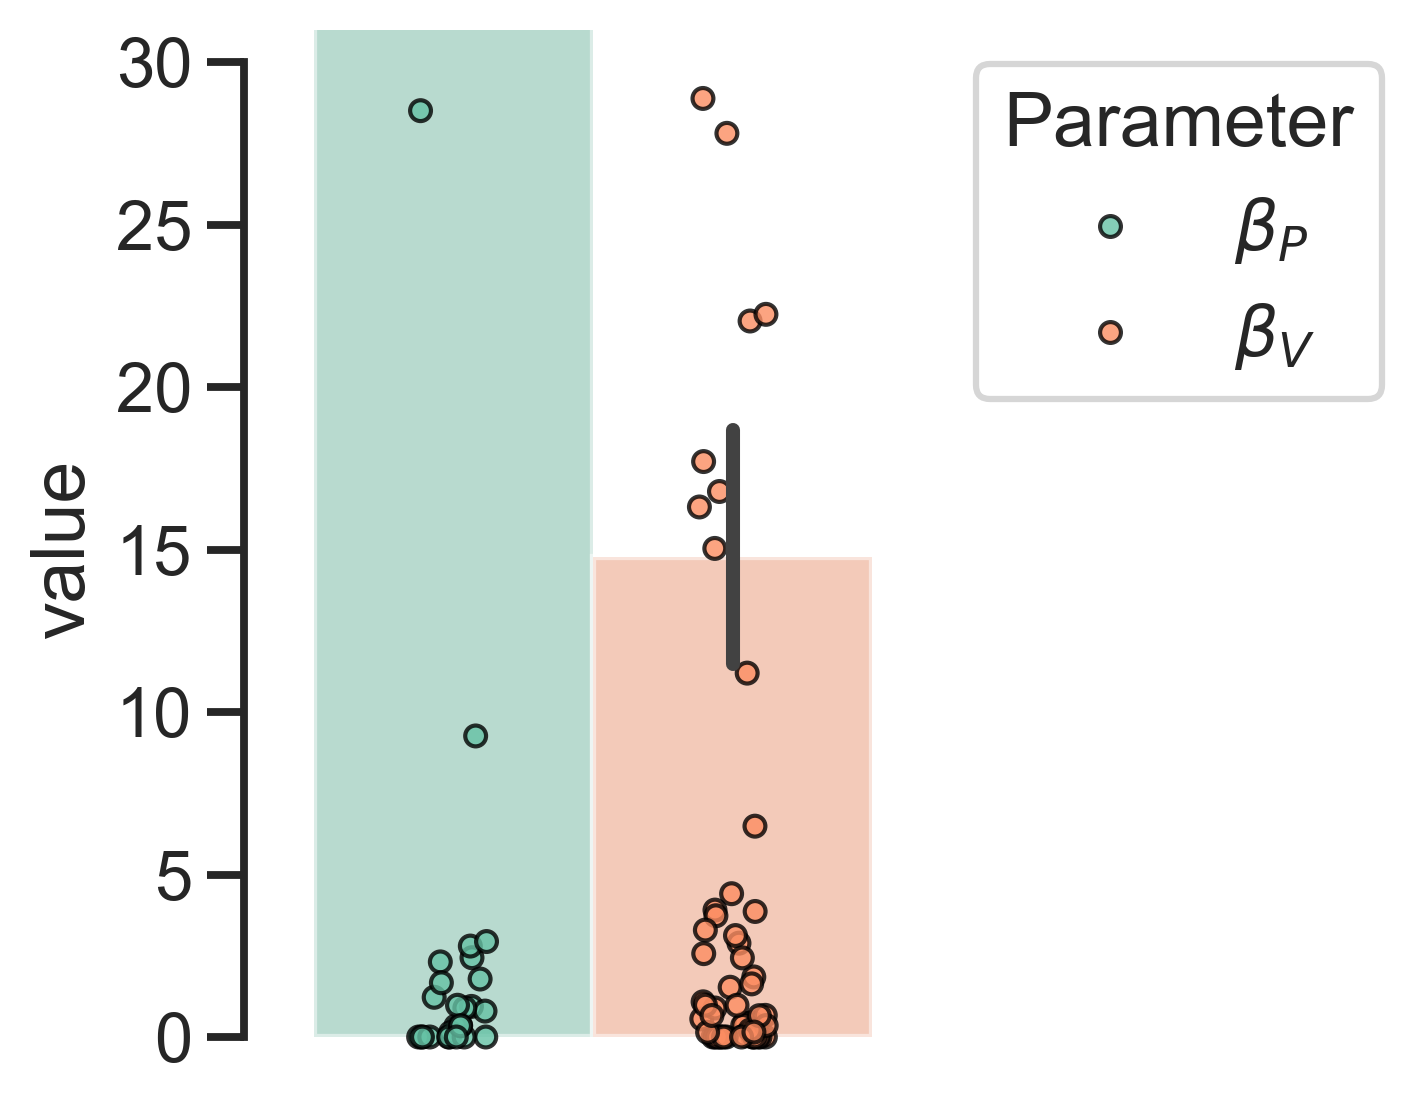

In [ ]:
sns.set({'figure.figsize': (3, 4.5), 'figure.dpi': 300})
sns.set_style("ticks")
sns.set_context('talk')
# sns.pointplot(data=d, x='expName', y='value', hue='param', linestyle="none", errorbar='se', errwidth=1.5, capsize=.1,
    # markersize=6, markeredgewidth=1, palette='Set2', dodge=True)
sns.barplot(data=dd, x='expName', y='value', hue='param', palette='Set2', dodge=True, alpha=.5, ci=68, zorder=-1)
sns.stripplot(data=dd, x='expName', y='value', hue='param', palette='Set2', jitter=0.1,alpha=.8, dodge=True, edgecolor='black', linewidth=1, zorder=1)
plt.ylim(-1, 31)
# plt.title('fitted parameters')
plt.xlabel('')
plt.xticks([])
# print legend with only two handles
handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles[2:], labels[2:], loc='outer right')
# legend outside the plot
plt.legend(handles[2:], labels[2:], title='Parameter', loc='upper left', bbox_to_anchor=(1, 1))
sns.despine(trim=True, bottom=True)

[  0.  50. 100. 150.]


C:\Users\garciaba\AppData\Local\Temp\ipykernel_32000\2125915897.py:18: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.5`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(y=y, x='expName', hue=hue, zorder=-1, data=df, alpha=.6, linecolor='w', bw=0.5, gap=.1, split=True,
C:\Users\garciaba\AppData\Local\Temp\ipykernel_32000\2125915897.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax=sns.pointplot(y=y, x='expName', hue=hue, zorder=2, data=df, dodge=True, ci=68, estimator=np.mean, markers='o', scale=1.3, color='black')
C:\Users\garciaba\AppData\Local\Temp\ipykernel_32000\2125915897.py:20: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  ax=sns.pointplot(y=y, x='expName', hue=hue, zorder=

([<matplotlib.axis.YTick at 0x203f79e7be0>,
 [Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150')])

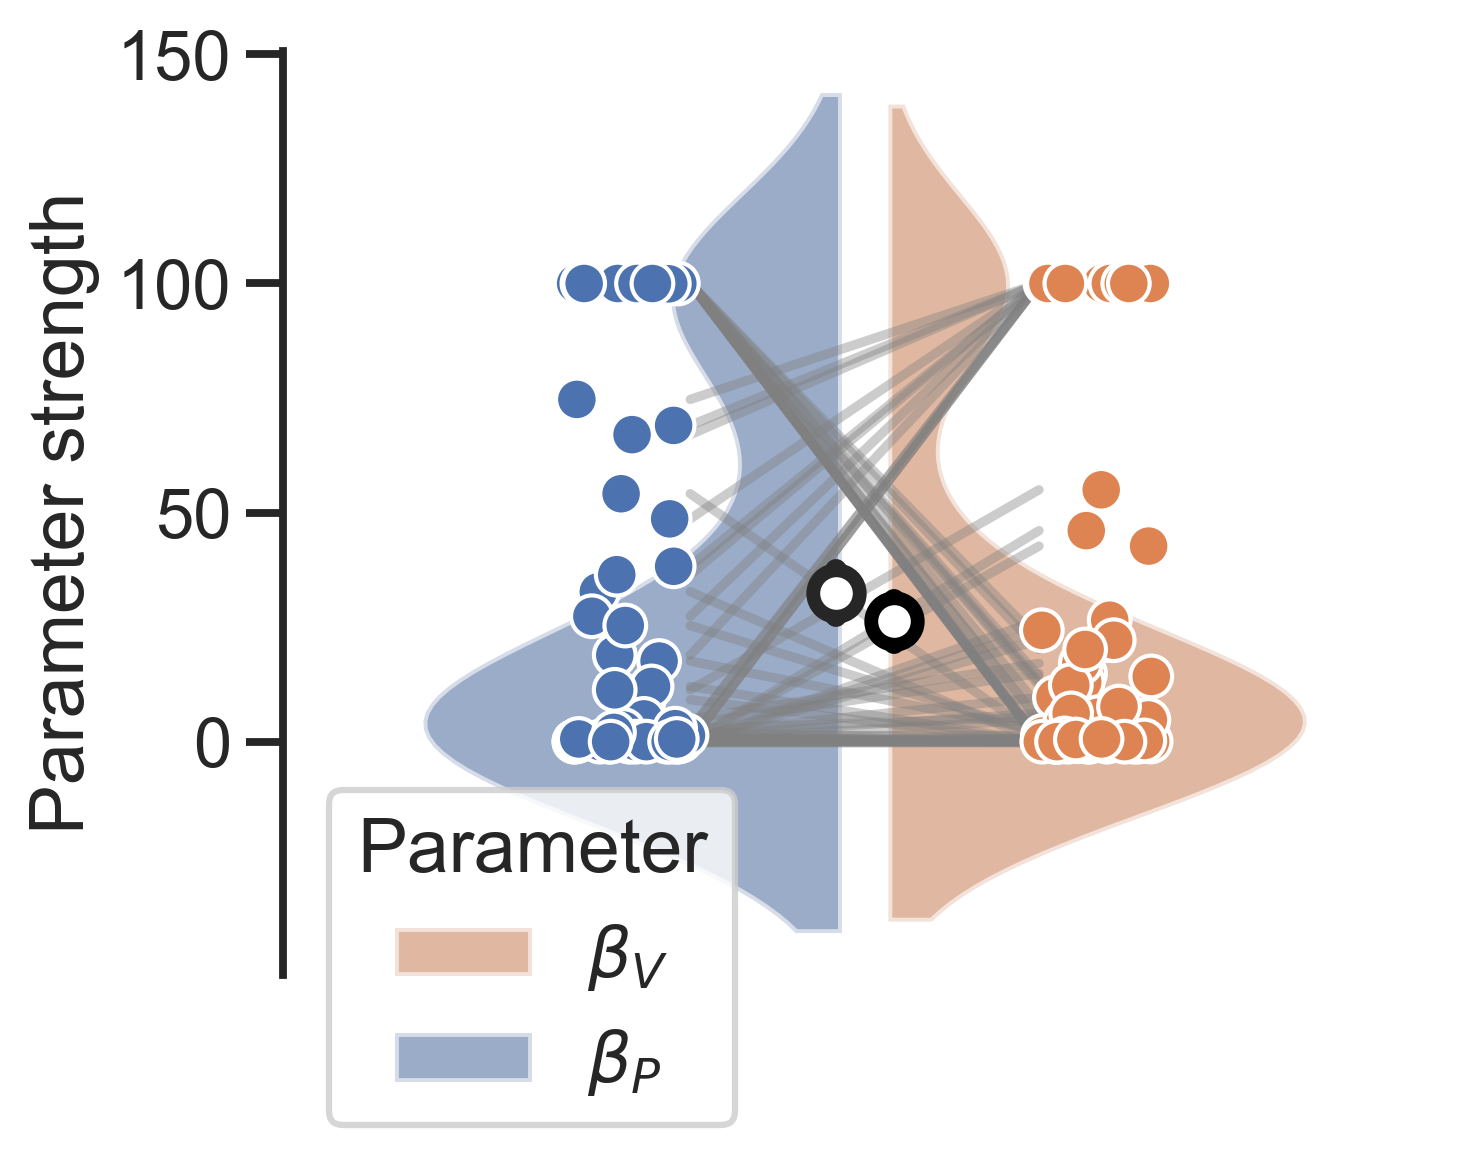

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set(rc={'figure.figsize':(5, 4), 'figure.dpi':300})
# set all fonts bigger
sns.set_context('talk')
sns.set_style('ticks')
# sns.set_style('dark')
# plt.style.use('dark_background')
# sns.set_palette('dark')
# sns.set_theme(style='dark')



def plot(y='value', hue='param', df=None):
    sns.violinplot(y=y, x='expName', hue=hue, zorder=-1, data=df, alpha=.6, linecolor='w', bw=0.5, gap=.1, split=True, 
                     inner_kws={'color': 'black', 'linewidth': 0.5}, palette=['C0', 'C1'], inner=None)
    ax=sns.pointplot(y=y, x='expName', hue=hue, zorder=2, data=df, dodge=True, ci=68, estimator=np.mean, markers='o', scale=1.3, color='black')
    m1 = df[df.param=='$\\beta_P$'].groupby('expName').mean(numeric_only=True).reset_index()
    m2 = df[df.param=='$\\beta_V$'].groupby('expName').mean(numeric_only=True).reset_index()
    # get x positon of the pointplot

    plt.scatter([-.025], m1.value, zorder=3, s=40, color='white')
    plt.scatter([.025], m2.value, zorder=3, s=40, color='white')
    ax = sns.stripplot(y=y, x='expName', hue=hue, zorder=1, size=10, 
                    data=df,dodge=True, edgecolor='white', linewidth=1, palette=['C0', 'C1'])
    # connect swarm dots with grey lines
    xlim = plt.xlim()
    # trace_lines_between_dots(df, y=y)
    # sns.lineplot(y=y, 
                #  x='expName', hue='pair2', zorder=2, style='pair2', 
                #    data=df_, alpha=1, color='grey', units='prolificID', estimator=None, legend=False
                #    )
    plt.xlim(xlim)
    trace_lines_between_dots(y=y, df=df)
    # plt.ylim(-.1, 1.1)
    # sns.pointplot(y=y, x='expName', hue='pair2', zorder=2, data=df_, dodge=True, ci=None, estimator=np.mean, markers='o', scale=1.5)
    
def get_x_from_y(y_value, ax, i):
    # Get the PathCollection (which contains the points' positions)
    collection = ax.collections[0]
    paths = collection.get_offsets()

    # Convert to a numpy array of points (x, y)
    points = np.array(paths)
    # Find the index of the closest point in terms of y value
    idx = (np.abs(points[:, 1] - y_value)).argmin()
    # Return the corresponding x value
    return points[idx, 0]      

# trace grey lines between hue categories swarm dots
# to do that we need to get the x position of each prolificID in the swarmplot
# and then draw a line between each pair of dots
def trace_lines_between_dots(y='opti_ss', ax=None, df=None):
    p1, p2 = df.param.unique()
    for j, expname in enumerate(np.sort(df.expName.unique())):
        for i, name in enumerate(df[df.expName==expname].agent.unique()):
            d1 = df[(df.agent==name) & (df.expName==expname) & (df.param==p1)]['value']
            assert len(d1) == 1
            d2 = df[(df.agent==name) & (df.expName==expname) & (df.param==p2)]['value']
            assert len(d2) == 1
            # d3 = df[(df.prolificID==name) & (df.expName==expname) & (df.y=='opti_ev')]['value']
            y2 = d2.values[0]
            y1 = d1.values[0]
            # y3 = d3.values[0]
            if ax:
                #this is the scatterplot ax
                # get the x position of the dot using y1, y2, y3
                # Function to find the x value corresponding to a given y value
                x1 = get_x_from_y(y1, ax, i)
                x2 = get_x_from_y(y2, ax, i)
                x3 = get_x_from_y(y3, ax, i)      
                plt.plot([x1, x2, x3], [y1, y2, y3], 'grey', alpha=.4)
                continue
                
            plt.plot([j-.15, j+.15], [y1, y2], 'grey', alpha=.4, zorder=-1)


# plt.subplot(1, 3, 1)
sns.set(rc={'figure.figsize':(5, 4), 'figure.dpi':300})

sns.set_context('talk')
sns.set_style('ticks')

#plt.plot([-0.5, len(df.session.unique())+.5], [0.5, 0.5], 'k--', alpha=0.5) 
# plt.plot([-0.5, 0.5], [0.5, 0.5], 'k--', alpha=0.5) 
dd = pd.read_csv('../data/processed/fit_params_fullpilot13.csv')
plot(y='value', df=dd)
plt.ylabel('Parameter strength')
sns.despine()
plt.xlabel('')
plt.xticks([])
#45 degree xticks
# plt.xticks(rotation=45)
# plt.legend([],[], frameon=False)
# only keep first two legend handles
handles = plt.gca().get_legend_handles_labels()[0]
# plt.legend(handles[0:3], ['spaceship', 'shield', 'optimal ev'], title='', loc='lower center', fontsize=12, title_fontsize=12)
# handle size
plt.xlabel('')

plt.tick_params(axis='x', length=0)
sns.despine(bottom=True)
# plt.xticks([0], ['session 1'])
param = dd.param.unique()
plt.legend(handles[:2][::-1], param[::-1], title='Parameter', bbox_to_anchor=(.01, -0.2), loc='lower left')
print(yticks)
plt.yticks(yticks)
# plt.legend().remove()

In [ ]:
from scipy.stats import ttest_rel
ttest_rel(dd[dd.param=='$\\beta_P$'].value, dd[dd.param=='$\\beta_V$'].value)

TtestResult(statistic=0.8273182851428539, pvalue=0.4111794748546158, df=63)

In [ ]:
# make a dataframe with the fitted values that are arrays of length 2 in a dic then convert to a dataframe
ddd = []
norm = lambda x: (x - x.min()) / (x.max() - x.min())
for agent, value in xopt.items():
    if agent not in df.prolificID.values:
        continue
    delta = value[0] - value[1]
    ddd.append({
        'agent': agent,
        'expName': df[df.prolificID==agent].expName.values[0],
        # 'model': 'NormativeEV',
        'opti_ff': value[0],
        'opti_ss': value[1],
    })
    
ddd = pd.DataFrame(ddd)

ddd['opti_ff'] = norm(ddd.opti_ff)
ddd['opti_ss'] = norm(ddd.opti_ss)
ddd['delta'] = ddd.opti_ff - ddd.opti_ss

# ddd['group'] = ddd.apply(lambda x:'perceptual' if x.delta > 0.1 else 'value' if x.delta < -0.1 else 'combined', axis=1)
ddd['group'] = None
ddd.to_csv('../data/processed/fitting_FullPilot12.csv', index=False)


In [ ]:
group_df = pd.read_csv('../data/processed/df_fullpilot12.csv')

# set group from group_df to ddd using prolificID and agent columns
ddd['group'] = ddd.apply(lambda x: group_df[group_df.prolificID==x.agent].group.values[0], axis=1)

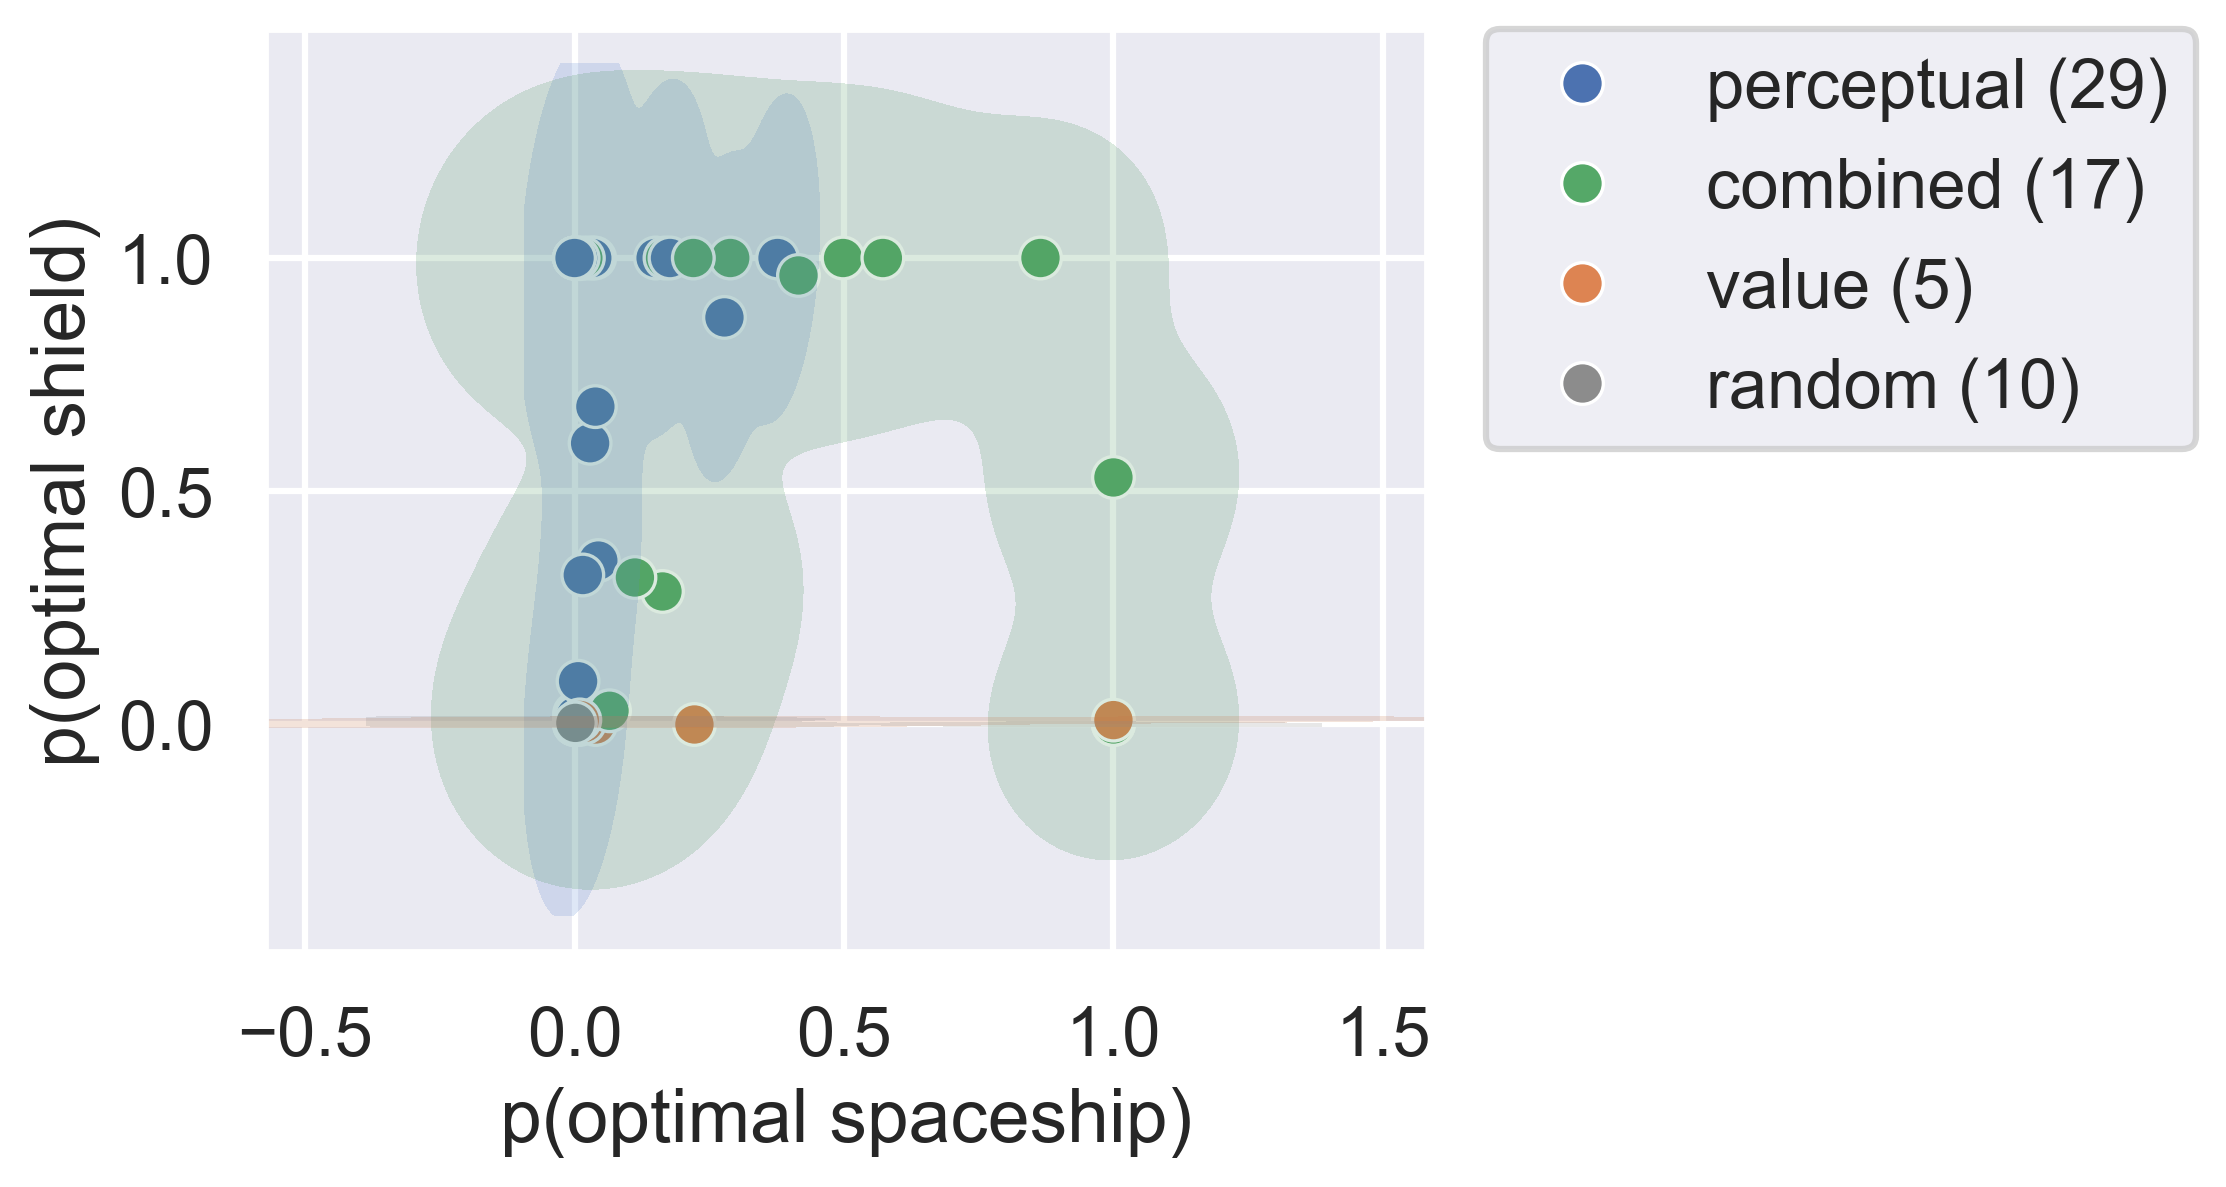

In [ ]:
# same but with scatterplot
sns.set(rc={'figure.figsize':(5,4)})
sns.set_context("talk")
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Function to create hand-drawn-like regions
def draw_handdrawn_region(center, hue, ax, radius=0.09, irregularity=0.004):
    # Generate random points around the center
    center = (center[0].mean(), center[1].mean())

    angles = np.linspace(0, 2 * np.pi, 20)
    # make it elliptical
    radius_x = radius - (radius/2)
    radius_y = radius + (radius/2)
    x_offsets = radius_x * np.cos(angles) + np.random.randn(20) * irregularity
    y_offsets = radius_y * np.sin(angles) + np.random.randn(20) * irregularity
    region_x = center[0] + x_offsets
    region_y = center[1] + y_offsets
    
    # clip the region to the axes boundaries in order to get oval shapes instead of circles
    # use max to cut off like 30% of the region

    # Fill the hand-drawn region with alpha
    ax.fill(region_x, region_y, color=hue, alpha=0.2, linewidth=0, zorder=2)

def draw_contour_region(center, hue, ax, radius=0.07):
    # Create a grid of points around the center
    x = np.linspace(center[0] - radius, center[0] + radius, 100)
    y = np.linspace(center[1] - radius, center[1] + radius, 100)
    X, Y = np.meshgrid(x, y)
    
    # Create a multivariate normal distribution for contour
    pos = np.dstack((X, Y))
    rv = multivariate_normal([center[0], center[1]], [[radius, 0], [0, radius]])
    Z = rv.pdf(pos)
    
    # Plot contourf for filled contours
    ax.contourf(X, Y, Z, levels=2, colors=hue, alpha=0.2)


df_ = ddd

# sort by group 
order = ['perceptual', 'combined', 'value', 'random']
df_['group'] = pd.Categorical(df_['group'], categories=order, ordered=True)
scatter = sns.scatterplot(data=df_, x='opti_ss', y='opti_ff', hue='group', palette=['C0', 'C2', 'C1', 'C7'], s=100)

# hightlight the clusters
# plt.axvline(0.5, color='gray', linestyle='--', alpha=0.2)
# plt.axhline(0.5, color='gray', linestyle='--', alpha=0.2)

# hightlight the clusters
# using seaborn, we want a region of interest using the colors of the clusters in scatterplot
sns.kdeplot(data=df_, x='opti_ss', y='opti_ff', alpha=0.2, fill=True, palette=['C0', 'C2', 'C1', 'C7'], hue='group', levels=2, bw_adjust=0.6, thresh=0.001) 
# Draw kdeplot for clusters with sufficient points

# change legend labels to add N=xx
handles, labels = plt.gca().get_legend_handles_labels()
labels = [f'{label} ({len(df_[df_.group==label])})' for label in labels]
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1)
           , loc=2, borderaxespad=0.)
data = df_
data['hue'] = data['group']
data['x'] = data['opti_ss']
data['y'] = data['opti_ff']
for hue_value in data['hue'].unique():
    
    subset = data[data['hue'] == hue_value]
    # For small groups, draw manual circles
    if len(subset) <= 2:
             # For small groups, draw hand-drawn regions
        draw_handdrawn_region((subset['x'], subset['y']), 'C2', plt.gca())
            


# add a third dimension (opti_ev)
# plt.ylim(0.3, 1)
# plt.xlim(0.3, 1)
plt.xlabel('p(optimal spaceship)')
plt.ylabel('p(optimal shield)')
# put legend outside
N = len(data)
# plt.title(f'counterfactual+R/2; N={N}')

#no legend
# plt.legend().remove()

C:\Users\basil\AppData\Local\Temp\ipykernel_21068\967022716.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_, x='group', y='count', palette=['C0', 'C1', 'C2'])


ValueError: nan is not in list

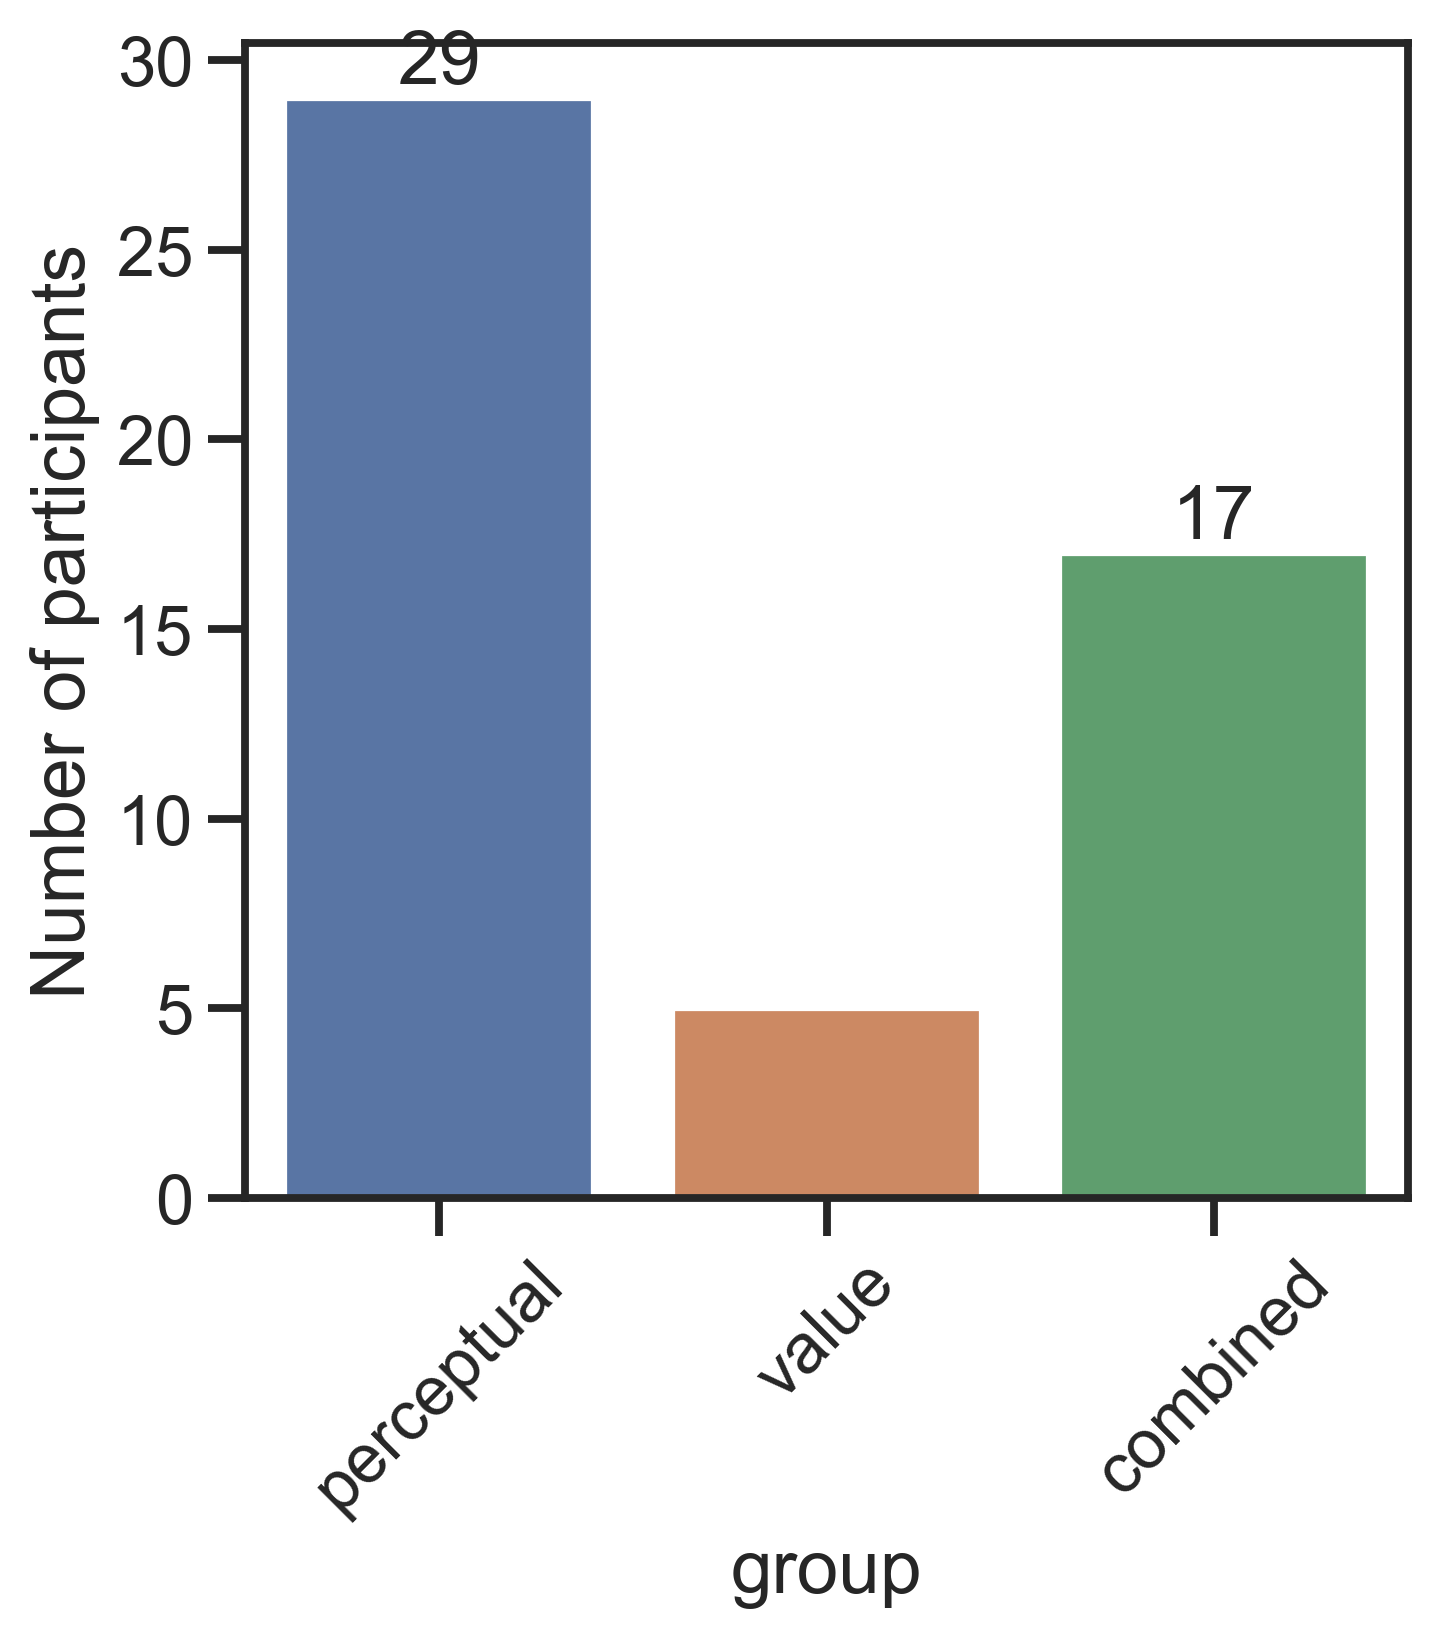

In [ ]:
import matplotlib.pyplot as plt
# plot group distribution
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style("ticks")
sns.set_context('talk')
# create new df with count of participants in each group
df_ = ddd.groupby(['group']).size().reset_index(name='count')
order = ['perceptual', 'value', 'combined']
df_['group'] = pd.Categorical(df_['group'], categories=order, ordered=True)
# sort by count
df_ = df_.sort_values('count', ascending=False)
sns.barplot(data=df_, x='group', y='count', palette=['C0', 'C1', 'C2'])
plt.xticks(rotation=45)
plt.ylabel('Number of participants')

# annotate with count of participants
# order is 1=perceptual, 2=balanced, 3=value
for i, row in df_.iterrows():
    order_idx = order.index(row['group'])
    # plt.text(order_idx, row['count'], row['count'], ha='center')
    # annotate with count of participants
    # for each hue, so 6 annotations, 2 for each hue
    plt.text(order_idx, row['count'], row['count'], ha='center', va='bottom')
    # the above is centered, we want to offset to left and right according to hue, so 
    # if i % 2 == 0, then offset to the left, else offset to the right
    # offset = -0.2 if i % 2 == 0 else 0.2
    # plt.text(order_idx + offset, row['count'], row['count'], ha='center', va='bottom')

sns.despine(trim=True)

In [ ]:
# print likelihood function
# -----------------------------------------------------------------
# parameters to tune
import itertools
from pybads import BADS
import scipy.optimize as opt
from tqdm.notebook import tqdm
# timeit

pbar = tqdm(total=len(df.agent.unique()))

#install IPyWidgets

# space = np.arange(0, 100, 5)
space = np.linspace(0, 20, 20)
space_all = np.array(list(itertools.product(space, repeat=2)))
# import pyfmincon.opt
# pyfmincon.opt.connect()
d = []

xopt = {}
for agent in df.agent.unique():
    df2 = df[df.agent==agent]
    s, a, r = df2.s.values, df2.a.values, df2.r.values
    ff1, ff2 = df2.ff1.values, df2.ff2.values
    destroy = df2.destroy.values
    ntrials = df2.shape[0]

    # xopt, fopt, fn1 = minimize(
        # f=fit,
        # args=(ntrials, s, a, r, destroy, ff1, ff2, map_ff_values.values()), space=space)
    
    # ...
    def target(x):
        return fit_pwf(x, *(ntrials, s, a, r, destroy, ff1, ff2, map_ff_values.values()))[0]

    lower_bounds = np.array([-10, -10])
    upper_bounds = np.array([10, 10])
    plausible_lower_bounds = np.array([1.0, 1.0])
    plausible_upper_bounds = np.array([5., 5.])
    # Starting point
    x0 = np.array([0, 0]);        

    bads = BADS(
        target,
        x0=x0[:1],
        lower_bounds=lower_bounds[:1],
        upper_bounds=upper_bounds[:1],
        # plausible_lower_bounds=plausible_lower_bounds[:1],
        # plausible_upper_bounds=plausible_upper_bounds[:1],
        options={'display': 'off'}
    )
    
    # xopt[agent] = opt.minimize(target, x0[:1], bounds=[(-10, 10)]).x[0]

    optimize_result = bads.optimize()
    
    xopt[agent] = optimize_result.x[0]
    continue

    # d.append({
        # 'agent': agent,
        # 'model': 'NormativeEV',
        # 'param': 'temp',
        # 'value': xopt
    # })

    # for i in range(len(fn1)):
    #     d.append({
    #         'agent': agent,
    #         'model': 'NormativeEV',
    #         # 'original_model': df2.model.values[0],
    #         'fn': fn1[i],
    #         'space': space[i],
    #     }) 

    xopt, fopt, params, fn2 = minimize(
        f=fit,
        args=(ntrials, s, a, r, destroy, ff1, ff2, map_ff_values.values()), space=space_all)
    # # print(xopt)
    d.append({
        'agent': agent,
        'model': 'NormativeLogRatio',
        'param': 'rl_temp',
        'value': xopt[1],
        'params': params
    })
    
    # d.append({
    #     'agent': agent,
    #     'model': 'NormativeLogRatio',
    #     'param': 'perceptual_temp',
    #     'value': xopt[0],
    #     'params': params
    # })
    # # print(res)
    """ for i in range(len(fn2)):
        d.append({
            'agent': agent,
            'model': 'NormativeLogRatio',
            # 'original_model': df2.model.values[0],
            'fn': fn2[i],
          'param': 'rl_temp',
          'value': space_all[i][1]
        }) 
        d.append({
            'agent': agent,
            'model': 'NormativeLogRatio',
            'fn': fn2[i],
            'param': 'perceptual_temp',
            'value': space_all[i][0]
        })
 """
    pbar.update()


d = pd.DataFrame(d)
pbar.refresh()


  0%|          | 0/5 [00:00<?, ?it/s]

bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.


True

{'5dd4767b32288646716dc98a': 9.9994921875, '5cfb82a12bcca70018252f81': 9.999949035644532, '63316daa57747115376760da': 9.9994921875, '650ee274aa4447ac435b7830': 9.999949035644532, '5c5ac2869d974300015d81fc': 9.9994921875}


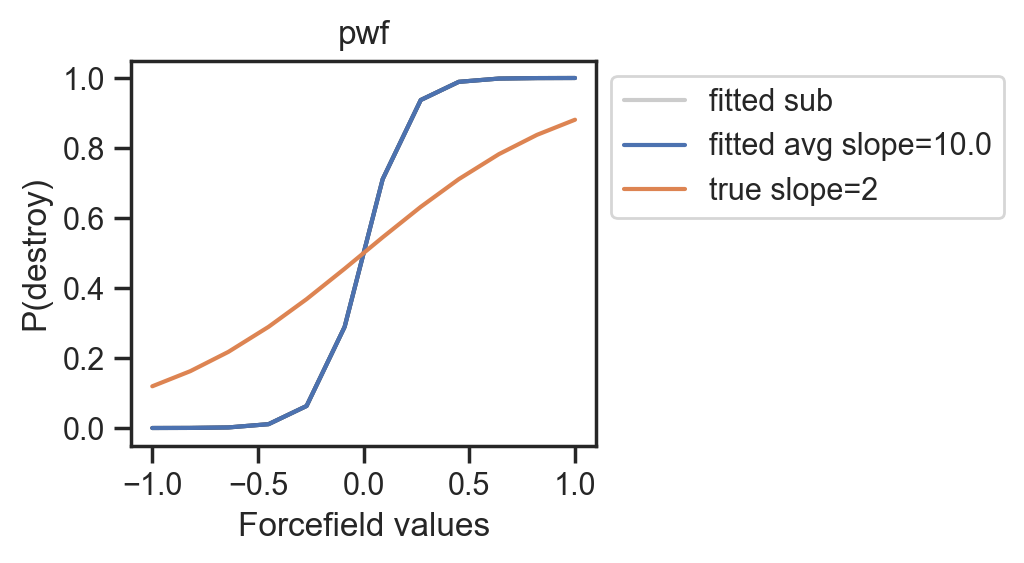

In [ ]:
# display function with slope = mean(xopt)
import matplotlib.pyplot as plt

logistic = lambda slope, x: 1/(1+np.exp(-slope*x))
x = np.linspace(-1, 1, 12).round(2)
slope = np.mean(list(xopt.values())).round(2)
# slope = xopt['5610c4ea7ffc8a0005811504']

sns.set({'figure.figsize': (3, 2.5), 'figure.dpi': 200})
sns.set_style('ticks')

ax = plt.gca()
for agent, value in xopt.items():
    ax.plot(x, logistic(value, x), alpha=.2, color='black', label='fitted sub')
ax.plot(x, logistic(slope, x), label=f'fitted avg slope={slope}', color='C0')
# plot true slope = 2
ax.plot(x, logistic(2, x), label='true slope=2', color='C1')
ax.set_xlabel('Forcefield values')
ax.set_ylabel('P(destroy)')
ax.set_title('pwf')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# keep only last three for legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-3:], labels[-3:], loc='upper left', bbox_to_anchor=(1, 1))
# loc of legend outside plot
print(xopt)

In [ ]:
df[df.prolificID=='5c5ac2869d974300015d81fc'].correct.mean()

0.75

In [ ]:
import scipy.optimize as opt
# i have probabilities (y)
# i need to find the x values that correspond to these probabilities
# i.e. the x values that give me the y values through the logistic function
# and find the slope that minimizes the difference between the x values and the forcefield values

x = np.unique([df.ff1.values, df.ff2.values])
y = np.unique([df.p1.values, df.p2.values])

def f(slope, x, y):
    return np.sum(np.abs(logistic(slope, x) - y))
    
opt.minimize(f, 0, args=(x, y))


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.01120414741166574
        x: [ 1.992e+00]
      nit: 5
      jac: [ 2.373e-02]
 hess_inv: [[ 3.238e-03]]
     nfev: 166
     njev: 77

In [ ]:
sns.set({'figure.figsize': (1, 2.5), 'figure.dpi': 200})
sns.set_style('ticks')

sns.boxplot(x='param', y='value', data=d)
# sns.stripplot(x='param', y='value', data=d,alpha=.9, palette='Set2')

ValueError: Could not interpret value `param` for `x`. An entry with this name does not appear in `data`.

IndexError: index -1 is out of bounds for axis 0 with size 0

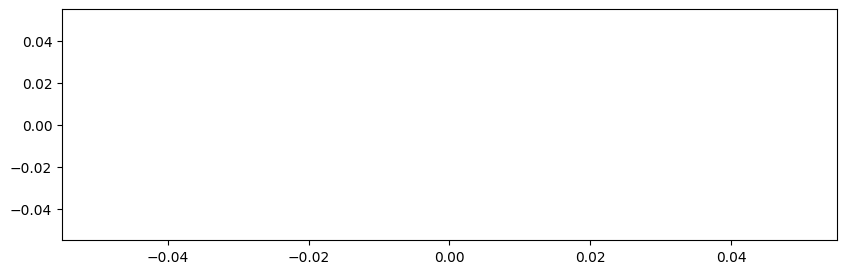

In [ ]:
#plot heatmap of liklihood (fn) for each parameter value (space)
dd = d[d.model=='NormativeEV']
plt.figure(figsize=(10, 3), dpi=100)
sns.lineplot(x='space', y='fn', data=dd, n_boot=0)
plt.ylabel('log likelihood')
plt.xlabel('$\\beta$')
plt.xticks(space)

# plt.xticks(space)


array([1.05263158, 8.42105263])

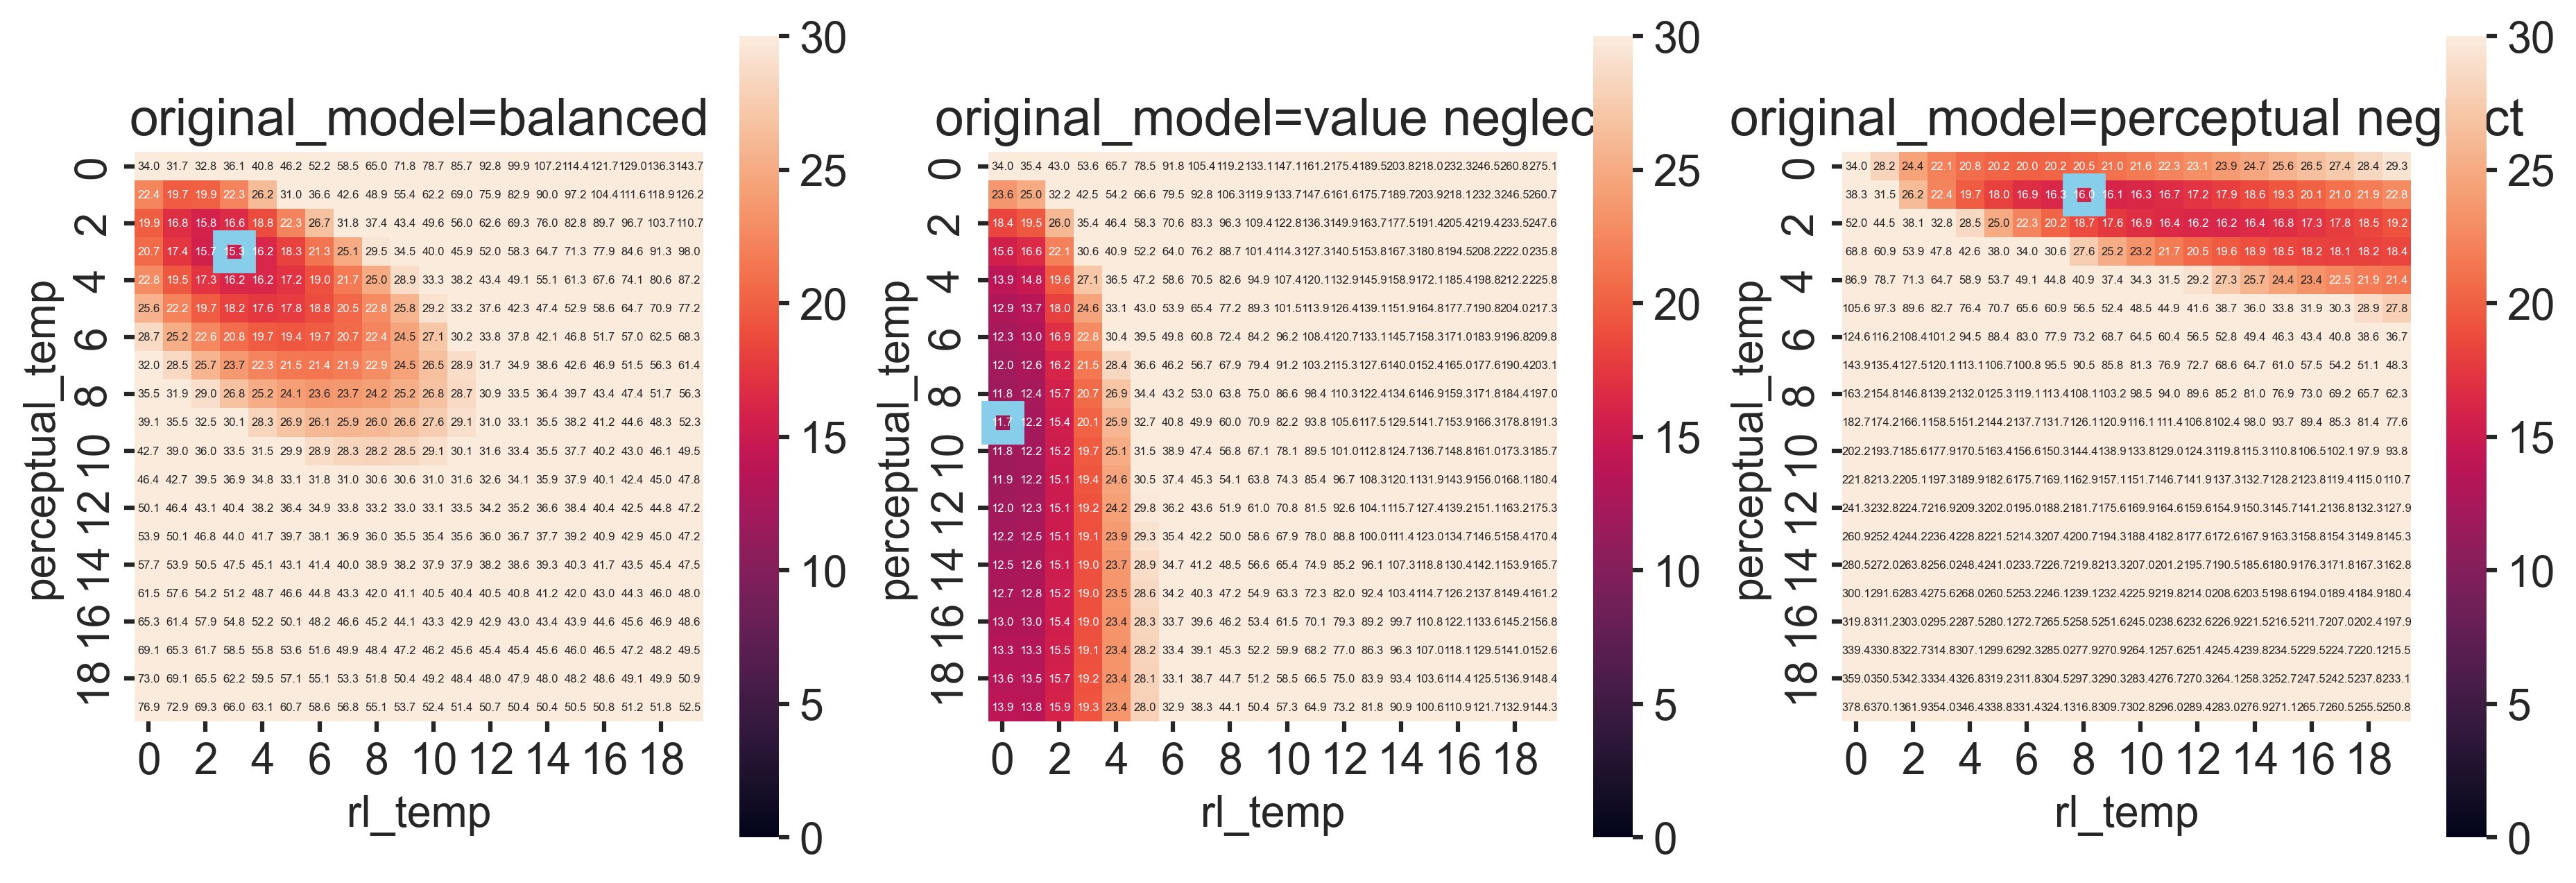

In [ ]:
# plot heatmap of liklihood (fn) for each parameter value (space)
dd = d[(d.model=='NormativeLogRatio') & (d.original_model!='random')]
plt.figure(figsize=(15, 5), dpi=300)
count = 0
for model in dd.original_model.unique():
    count += 1
    ddd = dd[dd.original_model==model].pivot(index='perceptual_temp', columns='rl_temp', values='fn')
    # change index and columns to int
    ddd.columns = ddd.columns.astype(int)
    ddd.index = ddd.index.astype(int)
    # xy = ddd.space.values
    # stack xy as a 2d array
    # xy = np.vstack(xy)
    # z = ddd.fn.values

    # plot heatmap
    plt.subplot(1, len(dd.original_model.unique()), count)
    # rs = len(space)
    
    plt.title(f'original_model={model}')
    ax = sns.heatmap(ddd,square=True, annot=True, annot_kws={"size": 4}, fmt='.1f', vmax=30, vmin=0)
    d_ = np.asarray(ddd)
    y,x = np.unravel_index(d_.argmin(), d_.shape)
    ax.add_patch(plt.Rectangle((x, y), 1, 1, fc='none', ec='skyblue', lw=5, clip_on=False))


space_all[np.argmin(ddd)]

In [ ]:
# manual fit
# -----------------------------------------------------------------
# parameters to tune
import itertools

pbar = tqdm(total=len(df.agent.unique()))
space = np.concatenate([np.linspace(0, 10, 10), np.linspace(10, 50, 5)]).flatten().round(1)
print(space)
space_all = np.array(list(itertools.product(space, repeat=2)))

# import pyfmincon.opt
# pyfmincon.opt.connect()
d = []

for agent in df.agent.unique():

    df2 = df[(df.agent==agent)]
    s, a, r = df2.s.values, df2.a.values, df2.r.values
    ff1, ff2 = df2.ff1.values, df2.ff2.values
    destroy = df2.destroy.values
    ntrials = int(df2.trial.max())

    xopt, fopt = minimize(
        f=fit,
        args=(ntrials, s, a, r, destroy, ff1, ff2), nparam=1, space=space)
    
    d.append({
            'agent': agent,
            'model': 'NormativeEV',
            'original_model': df2['model'].values[0],
            'll': fopt,
            'fitted_temp': float(xopt),
            'temp': df2['temp'].values[0],
    })

    xopt, fopt = minimize(
        f=fit,
        args=(ntrials, s, a, r, destroy, ff1, ff2), nparam=2, space=space_all)
    # print(res)
    d.append({
        'agent' : agent,
        'model': 'NormativeLogRatio',
        'original_model': df2['model'].values[0],
        'll': fopt,
        'fitted_rl_temp': xopt[1],
        'fitted_perceptual_temp': xopt[0],
        'rl_temp': df2['rl_temp'].values[0],
        'perceptual_temp': df2['perceptual_temp'].values[0],
    })

    pbar.update()

pbar.refresh()

d = pd.DataFrame(d)


  0%|          | 0/50 [00:00<?, ?it/s]

[ 0.   1.1  2.2  3.3  4.4  5.6  6.7  7.8  8.9 10.  10.  20.  30.  40.
 50. ]


C:\Users\basil\AppData\Local\Temp\ipykernel_10288\3873129865.py:24: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ff_chosen = [ff1[t], ff2[t]][a[t]]
C:\Users\basil\AppData\Local\Temp\ipykernel_10288\3874629961.py:287: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  if p[a] == 0:
C:\Users\basil\AppData\Local\Temp\ipykernel_10288\3874629961.py:289: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return p[a]
C:\Users\basil\AppData\Local\Temp\ipykernel_10288\3874629961.py:326: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  if p[a] == 0:
C:\Users\basil\AppData\Local\Temp\ipykernel_10288\3874629961.py:329: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return p[a]
C:\Users\basil\AppData\Local\Temp\ipyke

In [ ]:
# parameter retrieval
import scipy.optimize as opt
# import fit


models = (NormativeLogRatio, )
pbar = tqdm(total=len(df.agent.unique()))
method = 'scipy'
ub = [100]
lb = [.001]
x0 = np.mean([ub, lb], axis=0).tolist()

import pyfmincon.opt
pyfmincon.opt.connect()
d = []


for agent in df.agent.unique():

    df2 = df[(df.agent==agent)]
    s, a, r = df2.s.values, df2.a.values, df2.r.values
    ff1, ff2 = df2.ff1.values, df2.ff2.values
    destroy = df2.destroy.values
    ntrials = int(df2.trial.max())

    # if method == 'matlab':
    #     x = pyfmincon.opt.fmincon(
    #             function='fit.fit',
    #             x0=x0,
    #             optional_args=[ntrials, s, a.astype(int), r, destroy.astype(int), ff1, ff2],
    #             lb=lb,
    #             ub=ub,
    #             options={}
    #     )
    #     xopt = x[0]
    #     fopt = x[1]


    # if method == 'scipy':
    #     res = opt.minimize(
    #         fit,
    #         x0,
    #         args=(ntrials, s, a, r, destroy, ff1, ff2), method='L-BFGS-B',
    #         bounds=[(0, 10)])
    #     # xopt, fopt = matlab.fmincon(
    #     xopt = res.x[0]
    #     fopt = res.fun

    # d.append({
    #     'agent': agent,
    #     'model': 'NormativeEV',
    #     'original_model': df2['model'].values[0],
    #     'll': fopt,
    #     'fitted_temp': float(xopt),
    #     'temp': df2['temp'].values[0],
    # })

    if method == 'matlab':
        x = pyfmincon.opt.fmincon(
                function='fit.fit2',
                x0=x0 * 2,
                # optional_args=[ntrials, s, a.astype(int), r, destroy.astype(int), ff1, ff2],
                optional_args=[ntrials, s],
                lb=lb * 2,
                ub=ub * 2,
                options={}
        )
        xopt = x[0]
        fopt = x[1]

    if method == 'scipy':
        res = opt.minimize(
            fit,
            x0 * 2,
            args=(ntrials, s, a, r, destroy, ff1, ff2), method='L-BFGS-B',
            bounds=[(0, 30), (0, 30)], options=dict(ftol=1e-8))
        
        xopt = res.x
        fopt = res.fun

    # print(res)
    d.append({
        'agent' : agent,
        'model': 'NormativeLogRatio',
        'original_model': df2['model'].values[0],
        'll': fopt,
        'fitted_rl_temp': xopt[1],
        'fitted_perceptual_temp': xopt[0],
        'rl_temp': df2['rl_temp'].values[0],
        'perceptual_temp': df2['perceptual_temp'].values[0],
    })

    pbar.update()

pbar.refresh()

d = pd.DataFrame(d)
d.to_csv('data/fit.csv', index=False)

  0%|          | 0/400 [00:00<?, ?it/s]

             T  dof alternative     p-val          CI95%   cohen-d     BF10  \
T-test -4.5985   58   two-sided  0.000024  [-11.7, -4.6]  1.187328  788.479   

           power  
T-test  0.994784  
               T  dof alternative         p-val          CI95%   cohen-d  \
T-test  5.637197   58   two-sided  5.358005e-07  [7.14, 14.99]  1.455518   

             BF10     power  
T-test  2.355e+04  0.999829  


SyntaxError: 'return' outside function (3859054300.py, line 96)

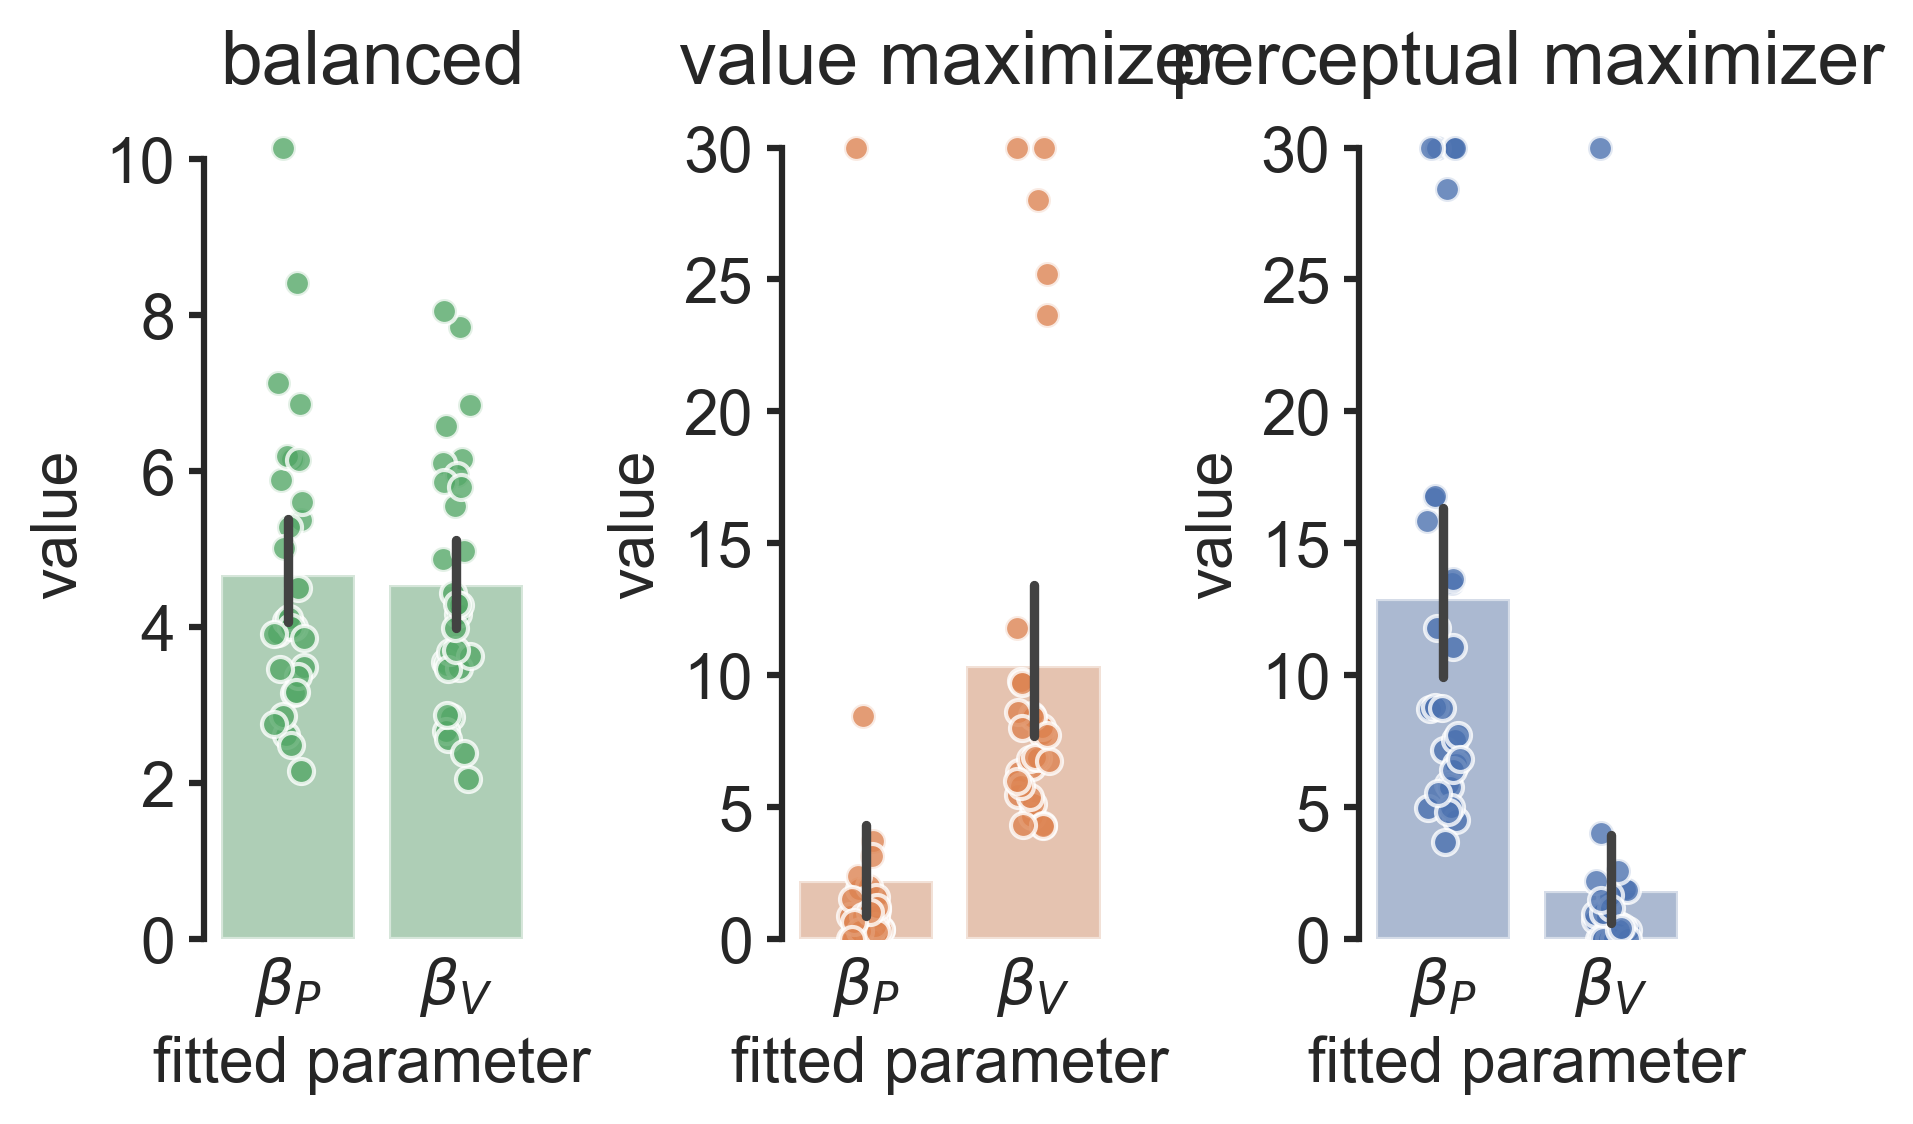

In [ ]:
# select 30 perceptual neglect
d = pd.read_csv('data/fit.csv')
np.random.seed(1)
n = 30
d1 = d[(d.model=='NormativeLogRatio') & (d.original_model=='perceptual neglect')].sample(n=n)
assert len(d1.agent.unique()) == n
d2 = d[(d.model=='NormativeLogRatio') & (d.original_model=='value neglect')].sample(n=n)
assert len(d2.agent.unique()) == n
d3 = d[(d.model=='NormativeLogRatio') & (d.original_model=='balanced')].sample(n=n)
assert len(d3.agent.unique()) == n
d4 = d[(d.model=='NormativeLogRatio') & (d.original_model=='random')].sample(n=n)
assert len(d3.agent.unique()) == n



models = [d1, d2, d3, d4]

# d_full = pd.DataFrame()
# d_full['parameter'] = ['perceptual_temp', ] * n
# d_full['value'] = d1.
d_full = pd.concat(models)
length = len(d_full)
dfull = pd.DataFrame()
dfull['parameter'] = ['$\\beta_P$', ] * length + ['$\\beta_V$', ] * length
dfull['value'] = d_full['fitted_perceptual_temp'].tolist() + d_full['fitted_rl_temp'].tolist()
dfull['model'] = d_full['original_model'].tolist() * 2

# remove outliers using stats zscore
from scipy import stats
dfull['z'] = np.abs(stats.zscore(dfull['value']))
# dfull = dfull[dfull.z < 3]


plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 300
# increase axes width
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
# increase font size
plt.rcParams.update({'font.size': 15})
sns.set_palette('deep')
palette = ['C2', 'C0', 'C1', 'grey']
sns.set_palette(palette=palette)

dfull1 = dfull[dfull.model=='balanced']
plt.subplot(1, 3, 1)
sns.barplot(x='parameter', y='value', data=dfull1, zorder=0, color='C0', alpha=.5)
sns.stripplot(x='parameter', y='value', data=dfull1,alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, color='C0')
plt.ylabel('value')
plt.xlabel('fitted parameter')
plt.title('balanced')
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)

dfull2 = dfull[dfull.model=='value neglect']
plt.subplot(1, 3, 3)
sns.barplot(x='parameter', y='value', data=dfull2, zorder=0, color='C1', alpha=.5)
sns.stripplot(x='parameter', y='value', data=dfull2,alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, color='C1')
plt.ylabel('value')
plt.xlabel('fitted parameter')
plt.title('perceptual maximizer')
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)


dfull3 = dfull[dfull.model=='perceptual neglect']
plt.subplot(1, 3, 2)
sns.barplot(x='parameter', y='value', data=dfull3, zorder=0, color='C2', alpha=.5)
sns.stripplot(x='parameter', y='value', data=dfull3,alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, color='C2')
plt.ylabel('value')
plt.xlabel('fitted parameter')
plt.title('value maximizer')
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)



plt.tight_layout()	
# plt.tick_params(axis='x', labelsize=8.5)
x1 = d_full[d_full.original_model=='perceptual neglect'].fitted_perceptual_temp
y1 = d_full[d_full.original_model=='value neglect'].fitted_perceptual_temp

x2 = d_full[d_full.original_model=='perceptual neglect'].fitted_rl_temp
y2 = d_full[d_full.original_model=='value neglect'].fitted_rl_temp

import pingouin as pg
print(pg.ttest(x1, x2))
print(pg.ttest(y1, y2))

plt.savefig('figs/result2.svg')

return

plt.subplot(1, 2, 2)
sns.barplot(x='original_model', y='fitted_rl_temp', data=dfull, alpha=.5, zorder=0, palette=['C2', 'C1'])
sns.stripplot(x='original_model', y='fitted_rl_temp', data=dfull, color='C0', alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, palette=['C2', 'C1'])
plt.ylabel('fitted $\\beta_V$')
plt.tick_params(axis='x', labelsize=8.5)
plt.tight_layout()


return
# add a column 
from scipy import stats
 
# dfull['z'] = np.abs(stats.zscore(dfull['fitted_perceptual_temp']))
# dfull = dfull[dfull.z < 2]
# dfull['z'] = np.abs(stats.zscore(dfull['fitted_rl_temp']))
# dfull = dfull[dfull.z < 2]

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 300
plt.subplot(1, 2, 1)
sns.barplot(x='original_model', y='fitted_perceptual_temp', data=dfull, zorder=0, palette=['C2', 'C1'])
sns.stripplot(x='original_model', y='fitted_perceptual_temp', data=dfull, color='C0', alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, palette=['C2', 'C1'])
plt.ylabel('fitted $\\beta_P$')
plt.tick_params(axis='x', labelsize=8.5)


plt.subplot(1, 2, 2)
sns.barplot(x='original_model', y='fitted_rl_temp', data=dfull, alpha=.5, zorder=0, palette=['C2', 'C1'])
sns.stripplot(x='original_model', y='fitted_rl_temp', data=dfull, color='C0', alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, palette=['C2', 'C1'])
plt.ylabel('fitted $\\beta_V$')
plt.tick_params(axis='x', labelsize=8.5)
plt.tight_layout()


x1 = dfull[dfull.original_model=='perceptual neglect'].fitted_perceptual_temp
y1 = dfull[dfull.original_model=='value neglect'].fitted_perceptual_temp

x2 = dfull[dfull.original_model=='perceptual neglect'].fitted_rl_temp
y2 = dfull[dfull.original_model=='value neglect'].fitted_rl_temp

import pingouin as pg
pg.ttest(x1, y1)


In [ ]:
dfull.fitted_perceptual_temp

322    1.887418
338    0.882236
134    2.017778
326    1.093613
374    0.247885
         ...   
204    4.744387
100    3.263421
24     3.691661
52     4.277753
276    3.527123
Name: fitted_perceptual_temp, Length: 105, dtype: float64

C:\Users\garciaba\AppData\Local\Temp\ipykernel_9524\2624842447.py:11: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2.5}` instead.

  sns.barplot(x='model', y='bic', hue='original_model', data=d, alpha=.2, zorder=-1, errwidth=2.5, capsize=0)


Text(0.5, 1.0, 'Model competition')

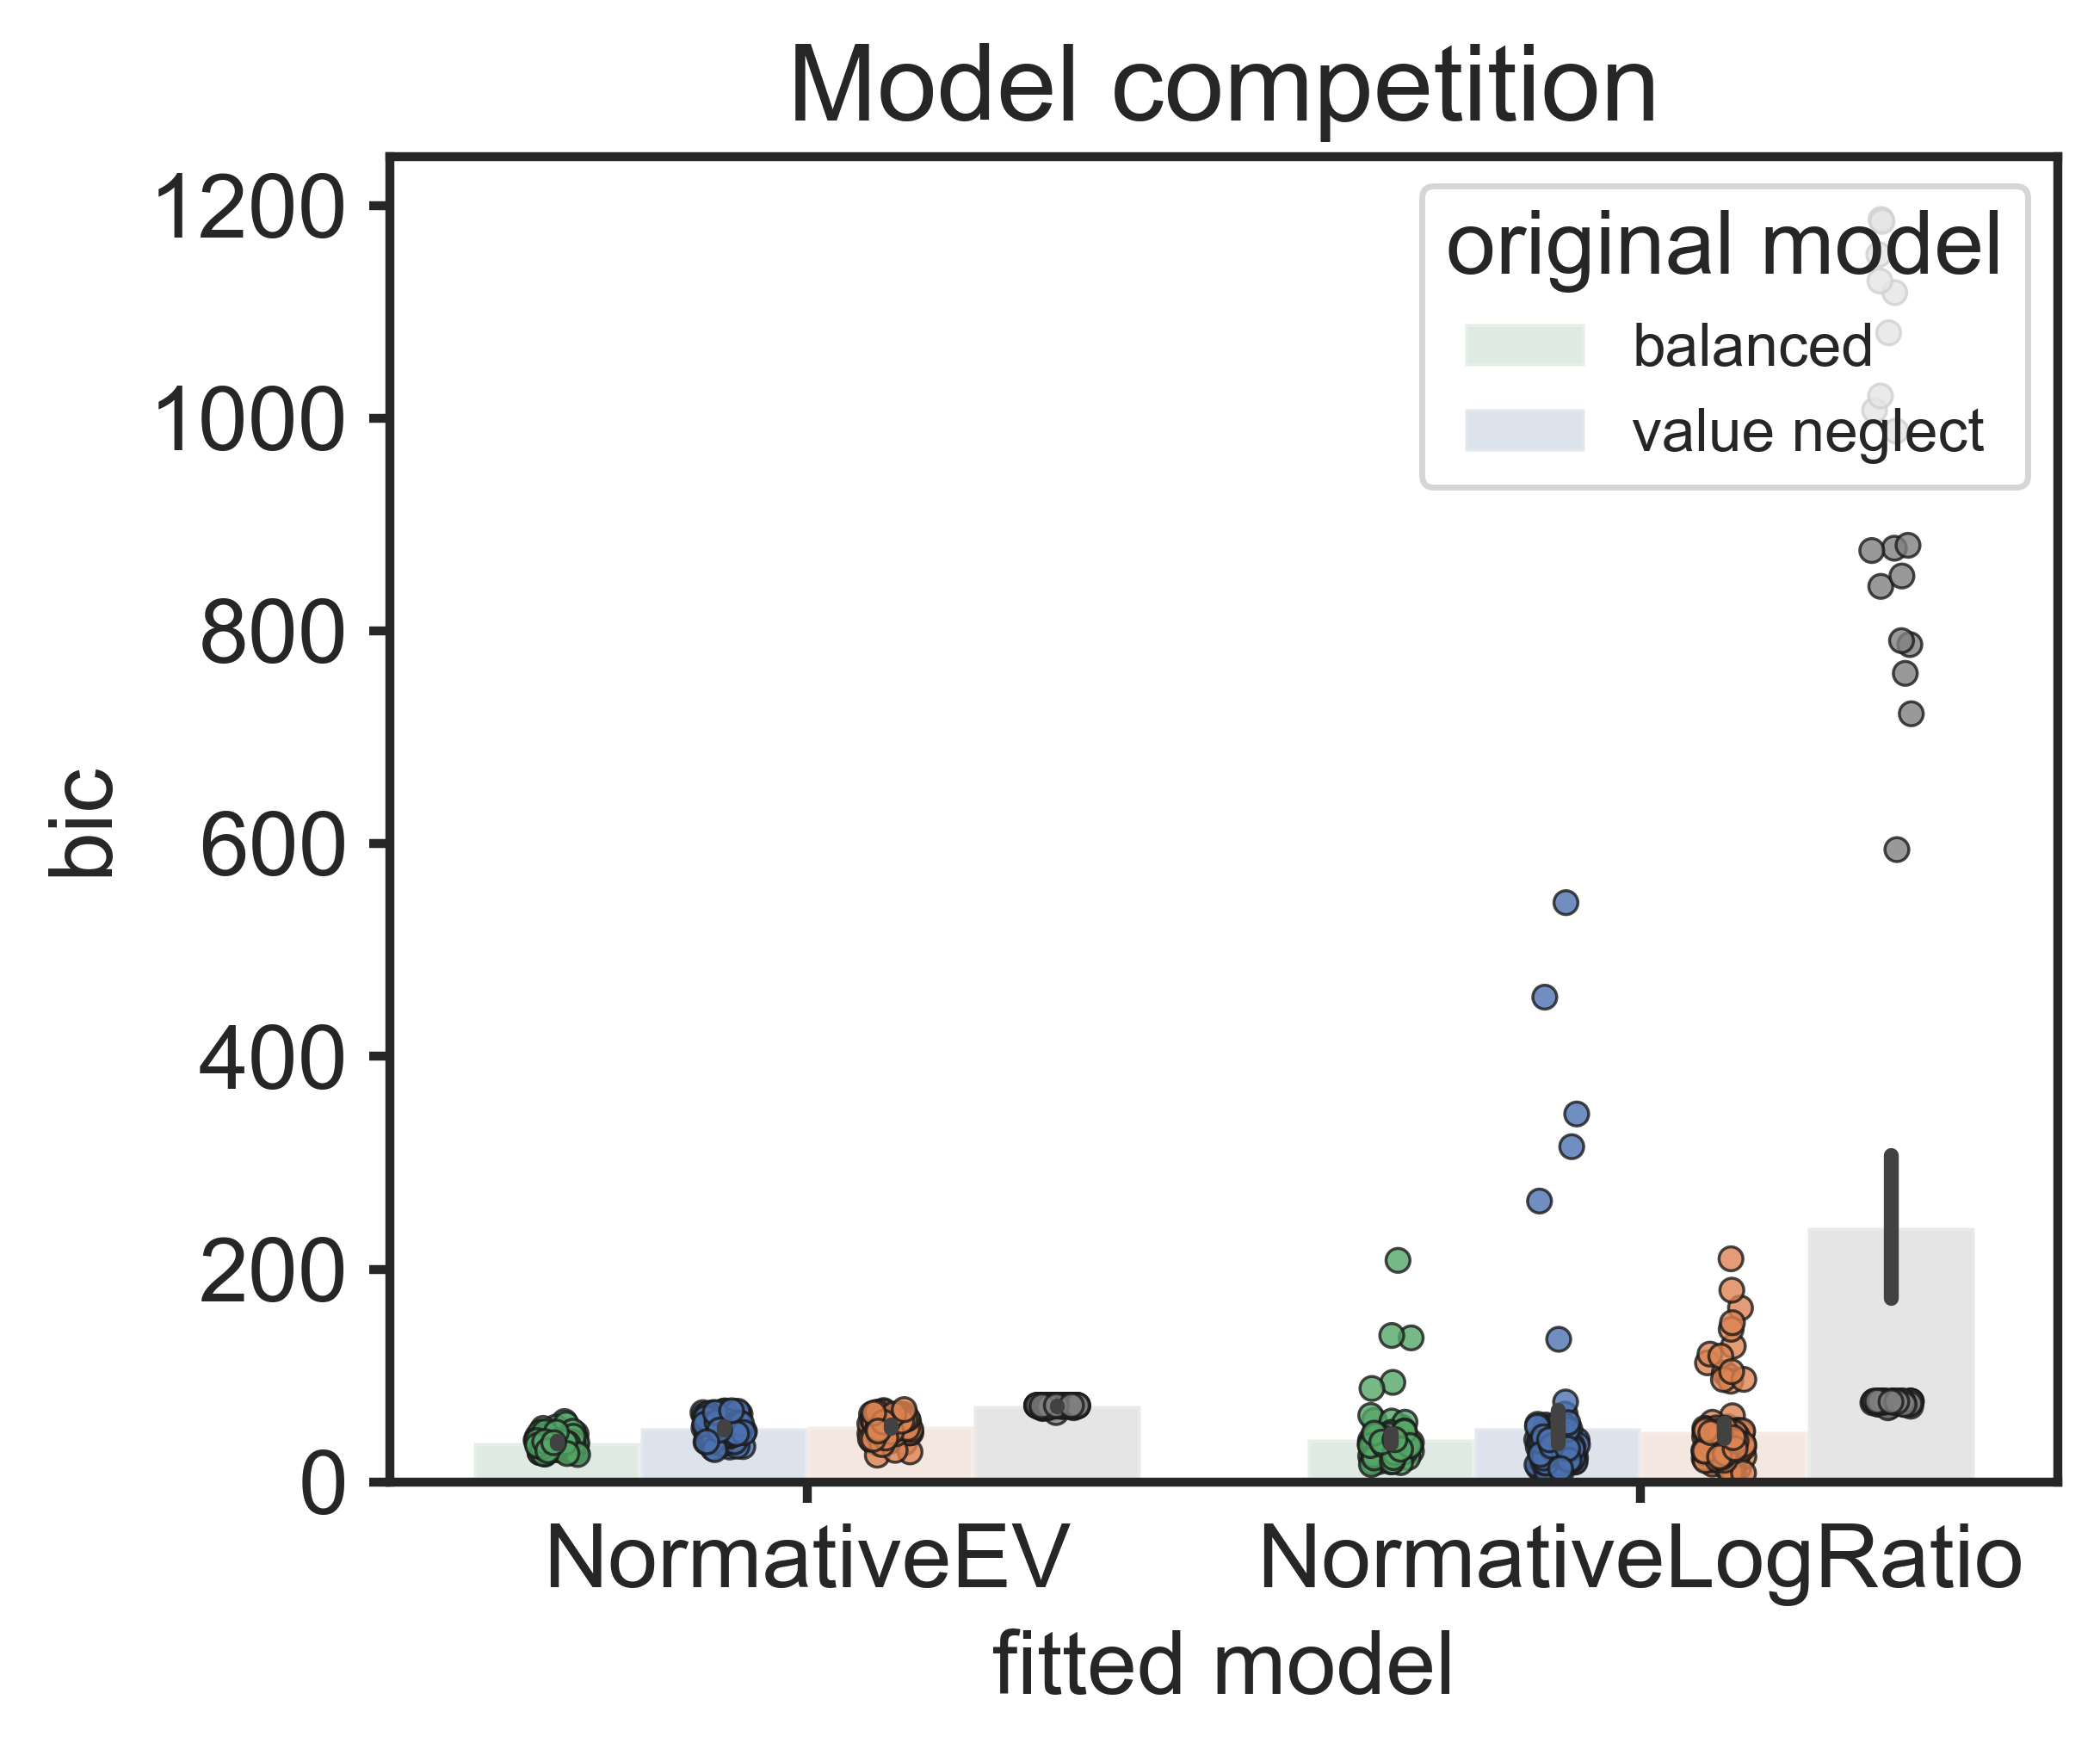

In [ ]:
# compute BIC 
d.loc[d.model=='NormativeLogRatio', 'bic'] = -2*-d[d.model=='NormativeLogRatio'].ll + np.log(ntrials)*2
d.loc[d.model=='NormativeEV', 'bic'] = -2*-d[d.model=='NormativeEV'].ll + np.log(ntrials)*1

# compute AIC
d.loc[d.model=='NormativeLogRatio', 'aic'] = -2*-d[d.model=='NormativeLogRatio'].ll + 2*2
d.loc[d.model=='NormativeEV', 'aic'] = -2*-d[d.model=='NormativeEV'].ll + 2*1

# plot BIC 
plt.figure(figsize=(5, 4), dpi=500)
sns.barplot(x='model', y='bic', hue='original_model', data=d, alpha=.2, zorder=-1, errwidth=2.5, capsize=0)

sns.stripplot(x='model', y='bic', hue='original_model', data=d, dodge=True, size=4, alpha=.8, zorder=1, linewidth=.5, edgecolor='k')
plt.xlabel('fitted model')

# Plot the legend for stripplot only
handles, labels = plt.gca().get_legend_handles_labels()
stripplot_legend = plt.legend(handles[:2], labels[:2], title='original model', loc='upper right')
plt.xlabel('fitted model')
plt.title('Model competition')

# Remove the default legend
# plt.gca().get_legend().remove()



In [ ]:
# plot fitted temp as barplot
plt.figure(figsize=(4, 5), dpi=500)
dd = d[d.model=='NormativeEV']
sns.barplot(x='original_model', y='fitted_temp', data=dd, alpha=.2, zorder=-1)
sns.stripplot(x='original_model', y='fitted_temp', data=dd, linewidth=.5, s=7,
               edgecolor='black', zorder=1, palette=['C0', 'C1'])
# plot true temp as a dot
# sns.scatterplot(x='original_model', y='temp', data=dd, color='k', s=100)
plt.ylabel('fitted temperature')
# plt.ylim(1e5, 1e7)
plt.title('NormativeEV fitted')




ValueError: Could not interpret input 'original_model'

<Figure size 2000x2500 with 0 Axes>

(20.0, 100.0)

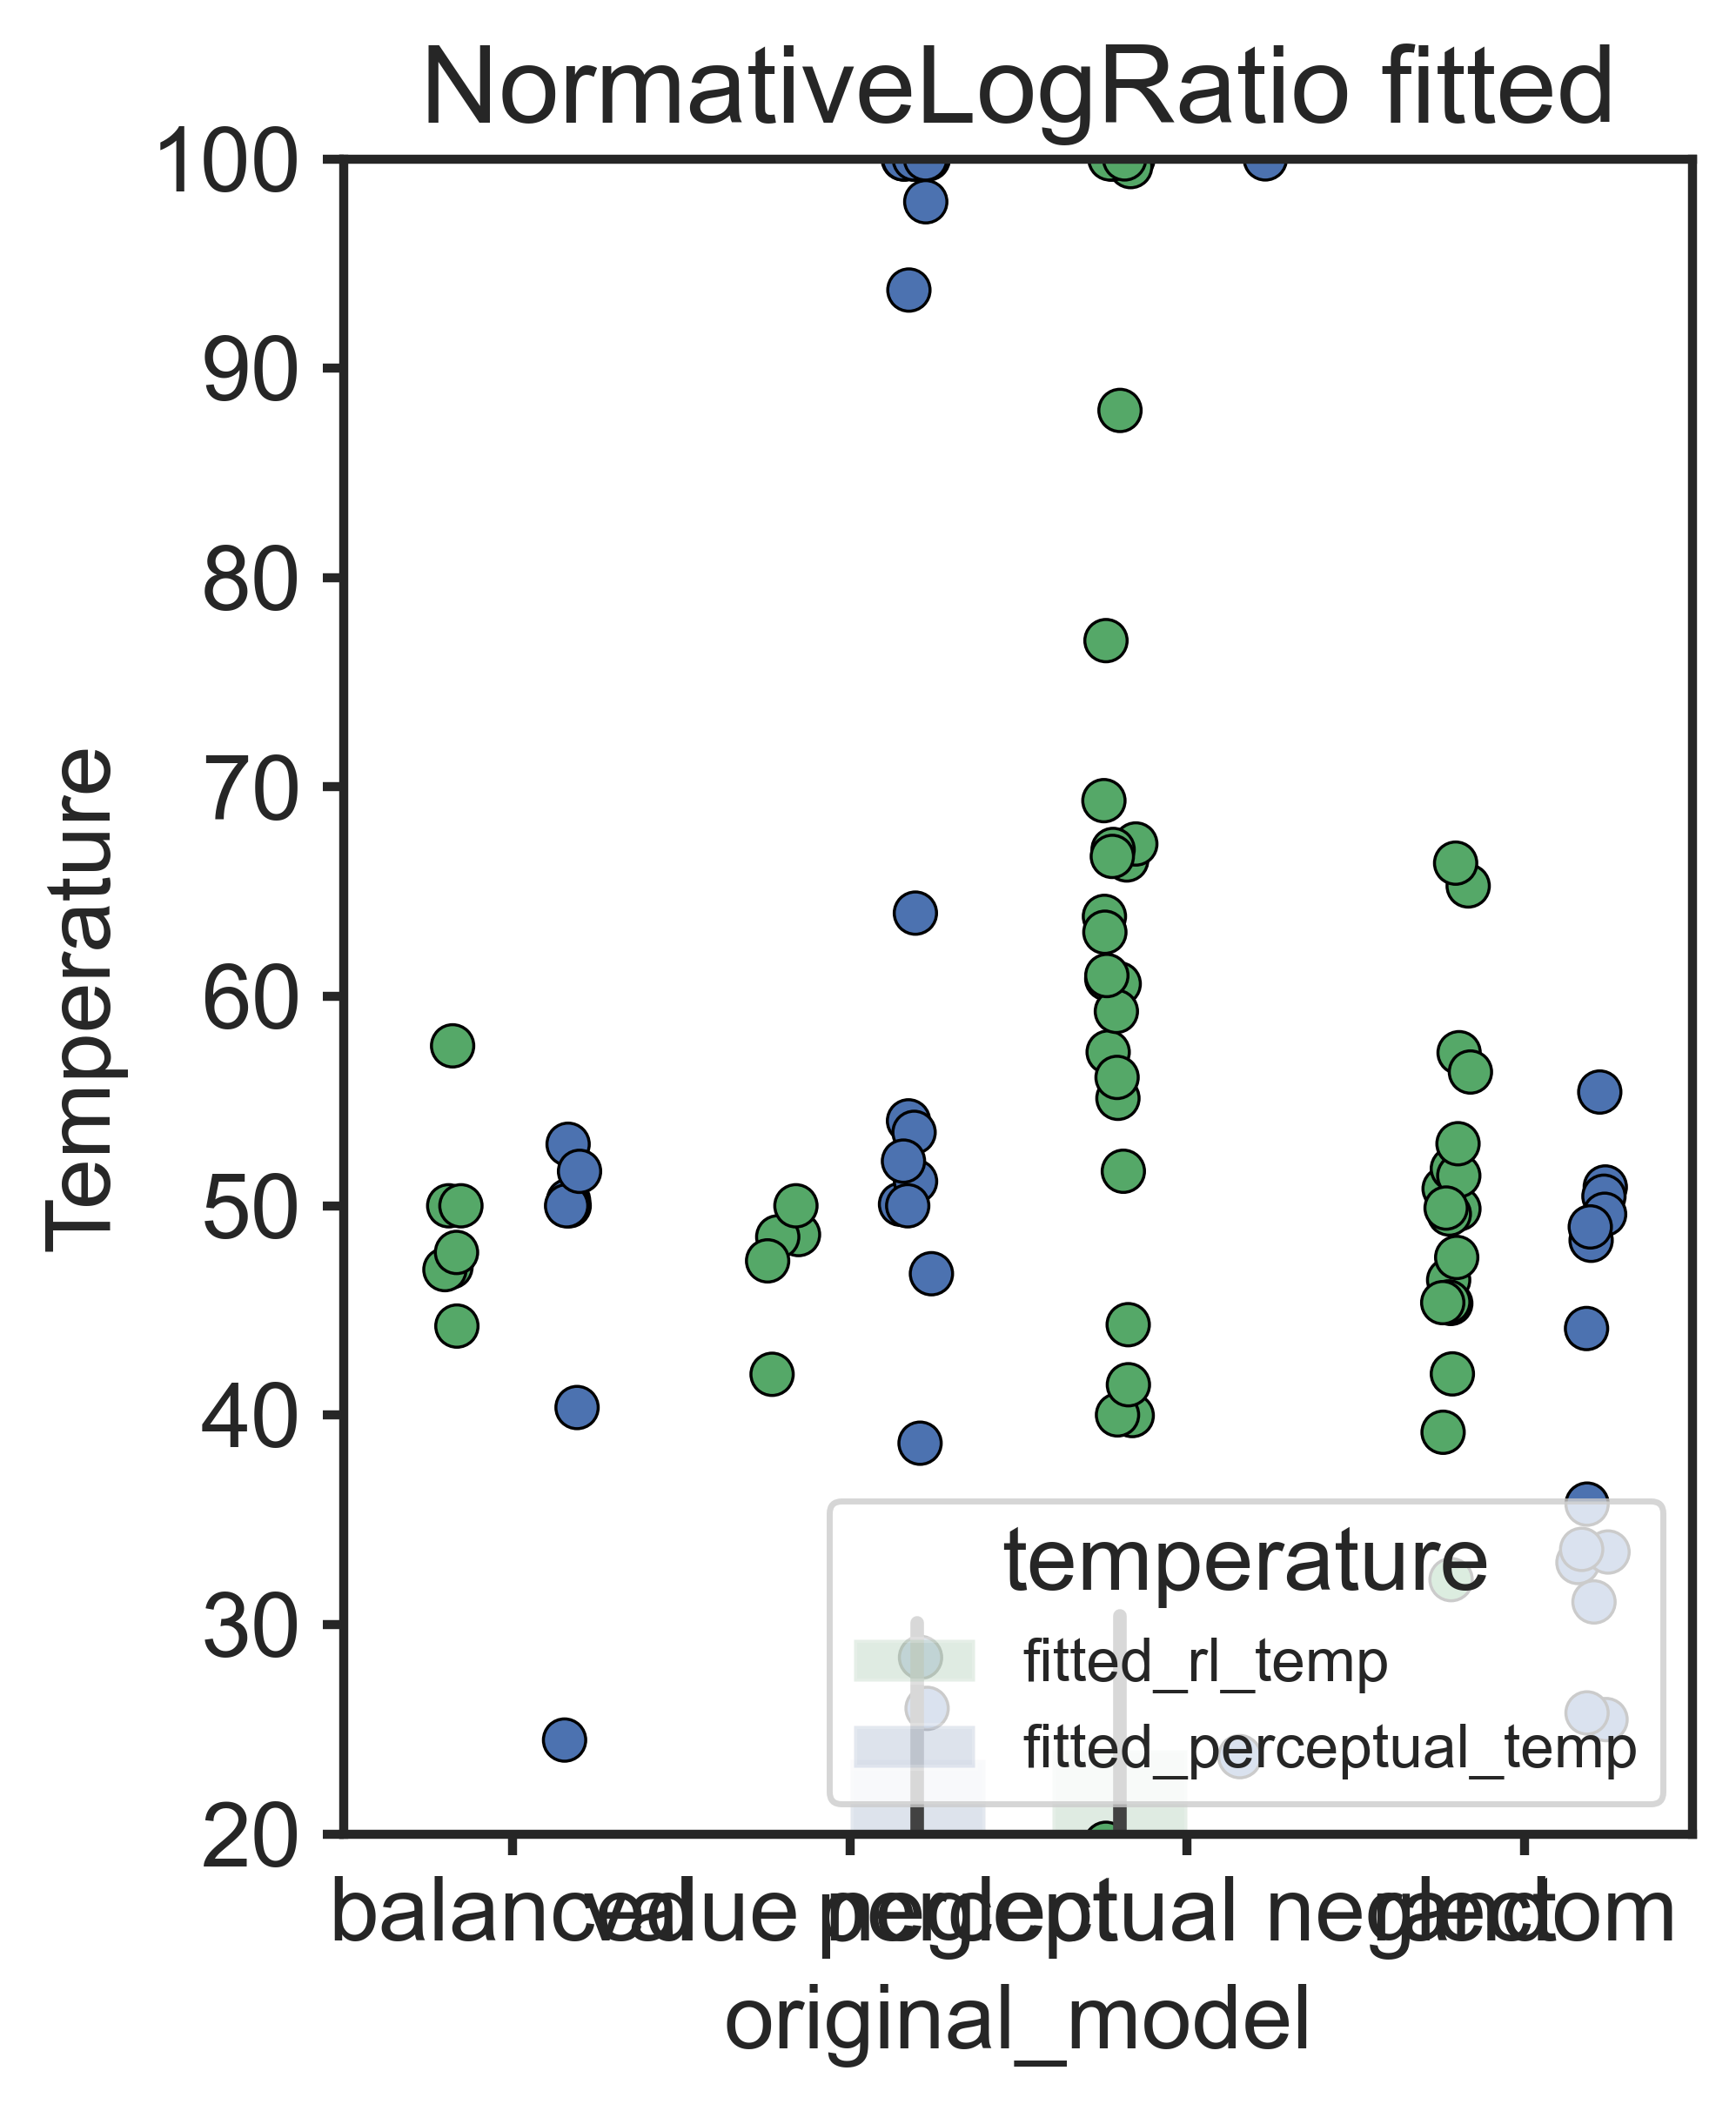

In [ ]:
plt.figure(figsize=(4, 5), dpi=500)
dd = d[d.model == 'NormativeLogRatio']

# Create a new DataFrame with the desired structure
df_combined = pd.DataFrame({
    'original_model': list(dd['original_model']) * 2,
    'variable': ['fitted_rl_temp'] * len(dd) + ['fitted_perceptual_temp'] * len(dd),
    'value': list(dd['fitted_rl_temp']) + list(dd['fitted_perceptual_temp'])
})

# Create a barplot with the new DataFrame
sns.barplot(
    x='original_model', y='value', hue='variable', data=df_combined, alpha=0.2)

# Add stripplot for additional data
sns.stripplot(
    x='original_model', y='value', hue='variable', data=df_combined, linewidth=0.5, s=7, edgecolor='black', zorder=1, dodge=True)

plt.ylabel('Temperature')
plt.title('NormativeLogRatio fitted')

# Customize the legend (optional)
# Plot the legend for stripplot only
handles, labels = plt.gca().get_legend_handles_labels()
stripplot_legend = plt.legend(handles[:2], labels[:2], title='temperature', loc='lower right')
plt.ylim([20, 100])



c:\Python312\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Python312\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 48.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(0.0, 21.0)

c:\Python312\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 29.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


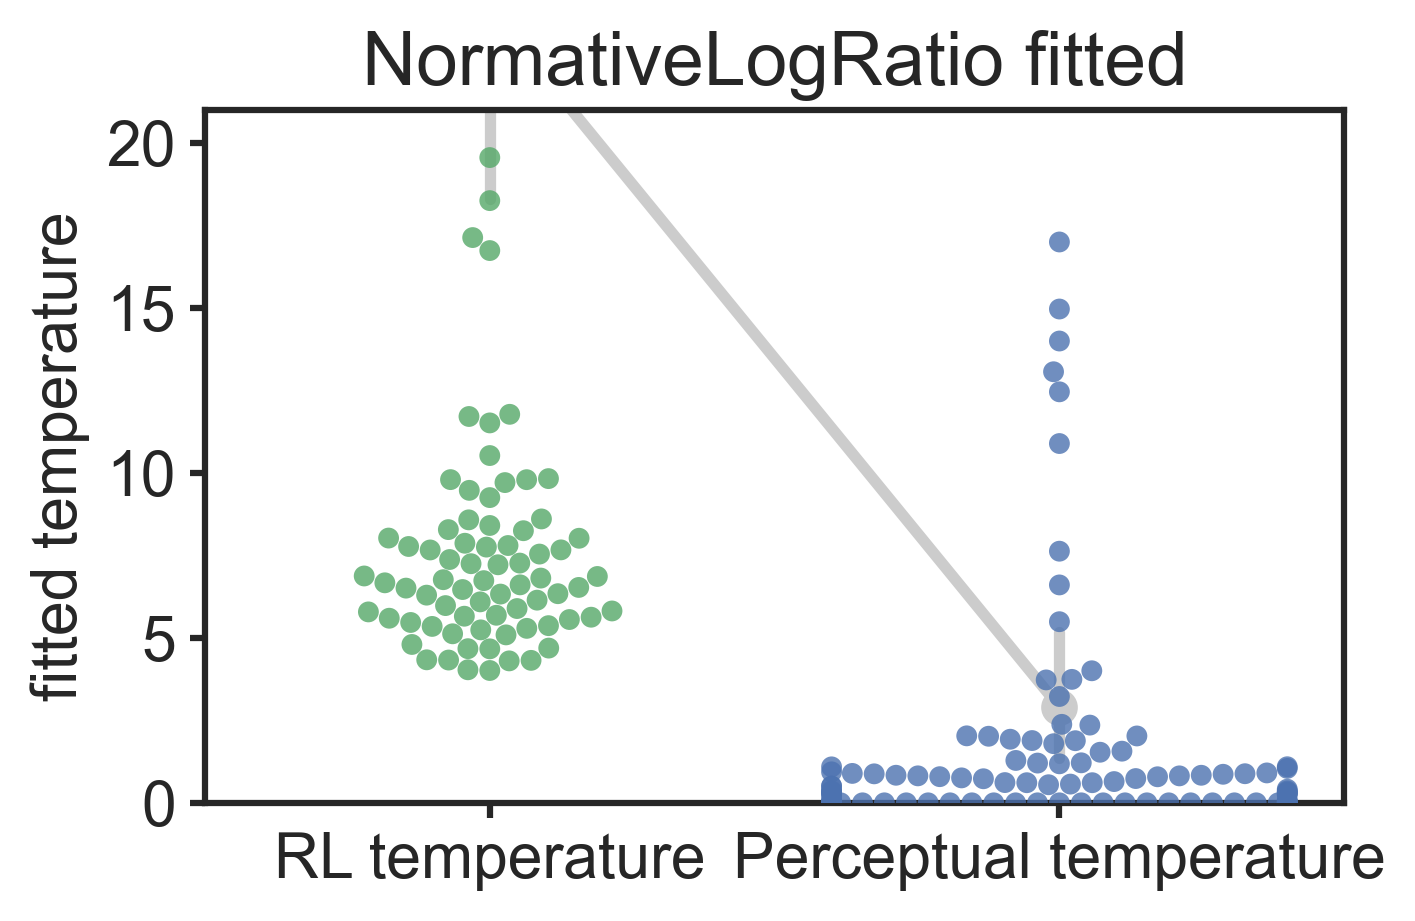

In [ ]:
# fitted rl temp and perceptual temp
plt.figure(figsize=(4.9, 3))
d3 = d[(d.model=='NormativeLogRatio') & (d.original_model=='perceptual neglect')]
# sns.barplot([d3['fitted_rl_temp'], d3['fitted_perceptual_temp']], alpha=.4)
# light grey color 
c = '#cccccc'
sns.pointplot([d3['fitted_rl_temp'], d3['fitted_perceptual_temp']], color=c)
sns.swarmplot([d3['fitted_rl_temp'], d3['fitted_perceptual_temp']], alpha=.8, zorder=2000)
# plt.ylim([5, 15])
plt.ylabel('fitted temperature')
plt.xticks([0, 1], ['RL temperature', 'Perceptual temperature'])
plt.title('NormativeLogRatio fitted')
plt.ylim([0, 21])

Text(0, 15, 'r=0.57, p=0.00')

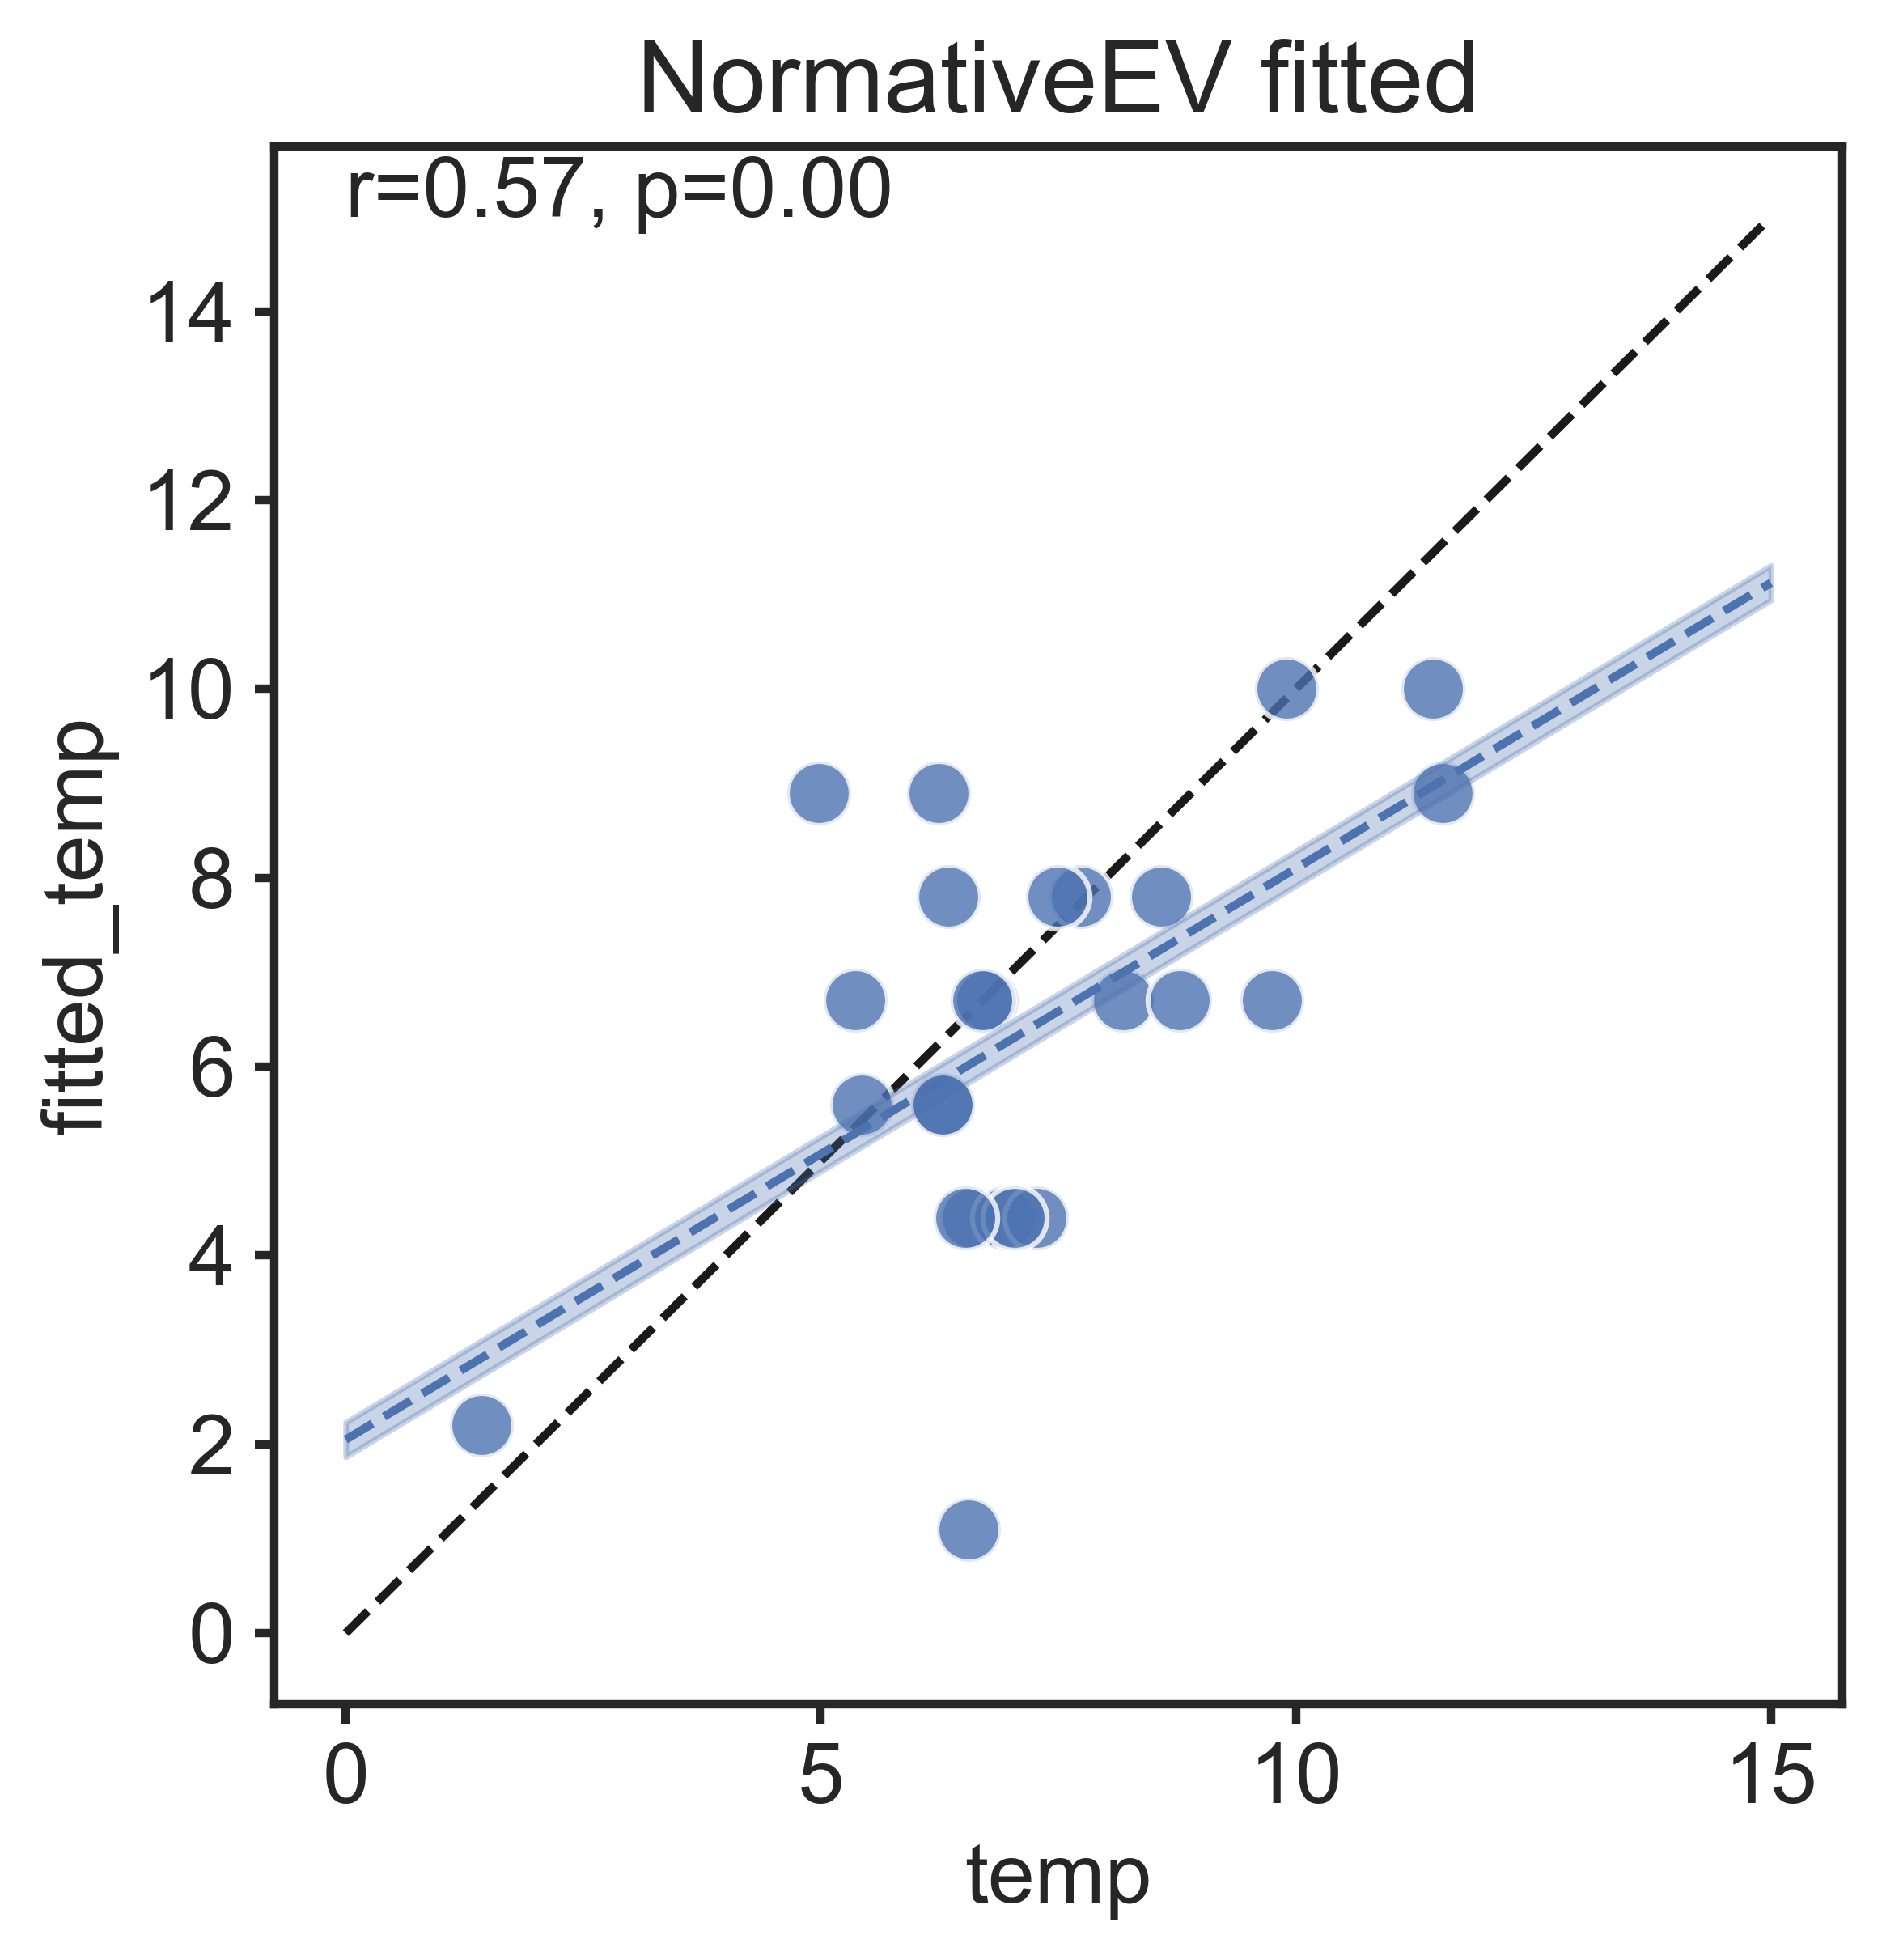

In [ ]:
# -----------------------------------------------------------------
# PLOT
# -----------------------------------------------------------------
max_ = 15
plt.figure(figsize=(5, 5), dpi=500)
d2 = d[(d.model=='NormativeEV') & (d.original_model=='NormativeEV')]
sns.scatterplot(x='temp', y='fitted_temp', data=d2, s=130, alpha=.8)
# plot identity
plt.plot([0, 15], [0, 15], color='k', linestyle='--', zorder=-1)
plt.title('NormativeEV fitted')
# return
# plot linear regression with scipy
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(d2['temp'], d2['fitted_temp'])
plt.plot([0, max_], [intercept, max_*slope+intercept], color='C0', linestyle='--')
# plot confidence interval
plt.fill_between([0, max_], [intercept-std_err, max_*slope+intercept-std_err], [intercept+std_err, max_*slope+intercept+std_err], alpha=.3, color='b')

from scipy.stats import pearsonr

r, p = pearsonr(d2['temp'].dropna(), d2['fitted_temp'].dropna())
plt.text(0, 15, f'r={r:.2f}, p={p:.2f}', fontdict={'fontsize': 15})

Text(2, 9, 'r=0.73, p=0.00')

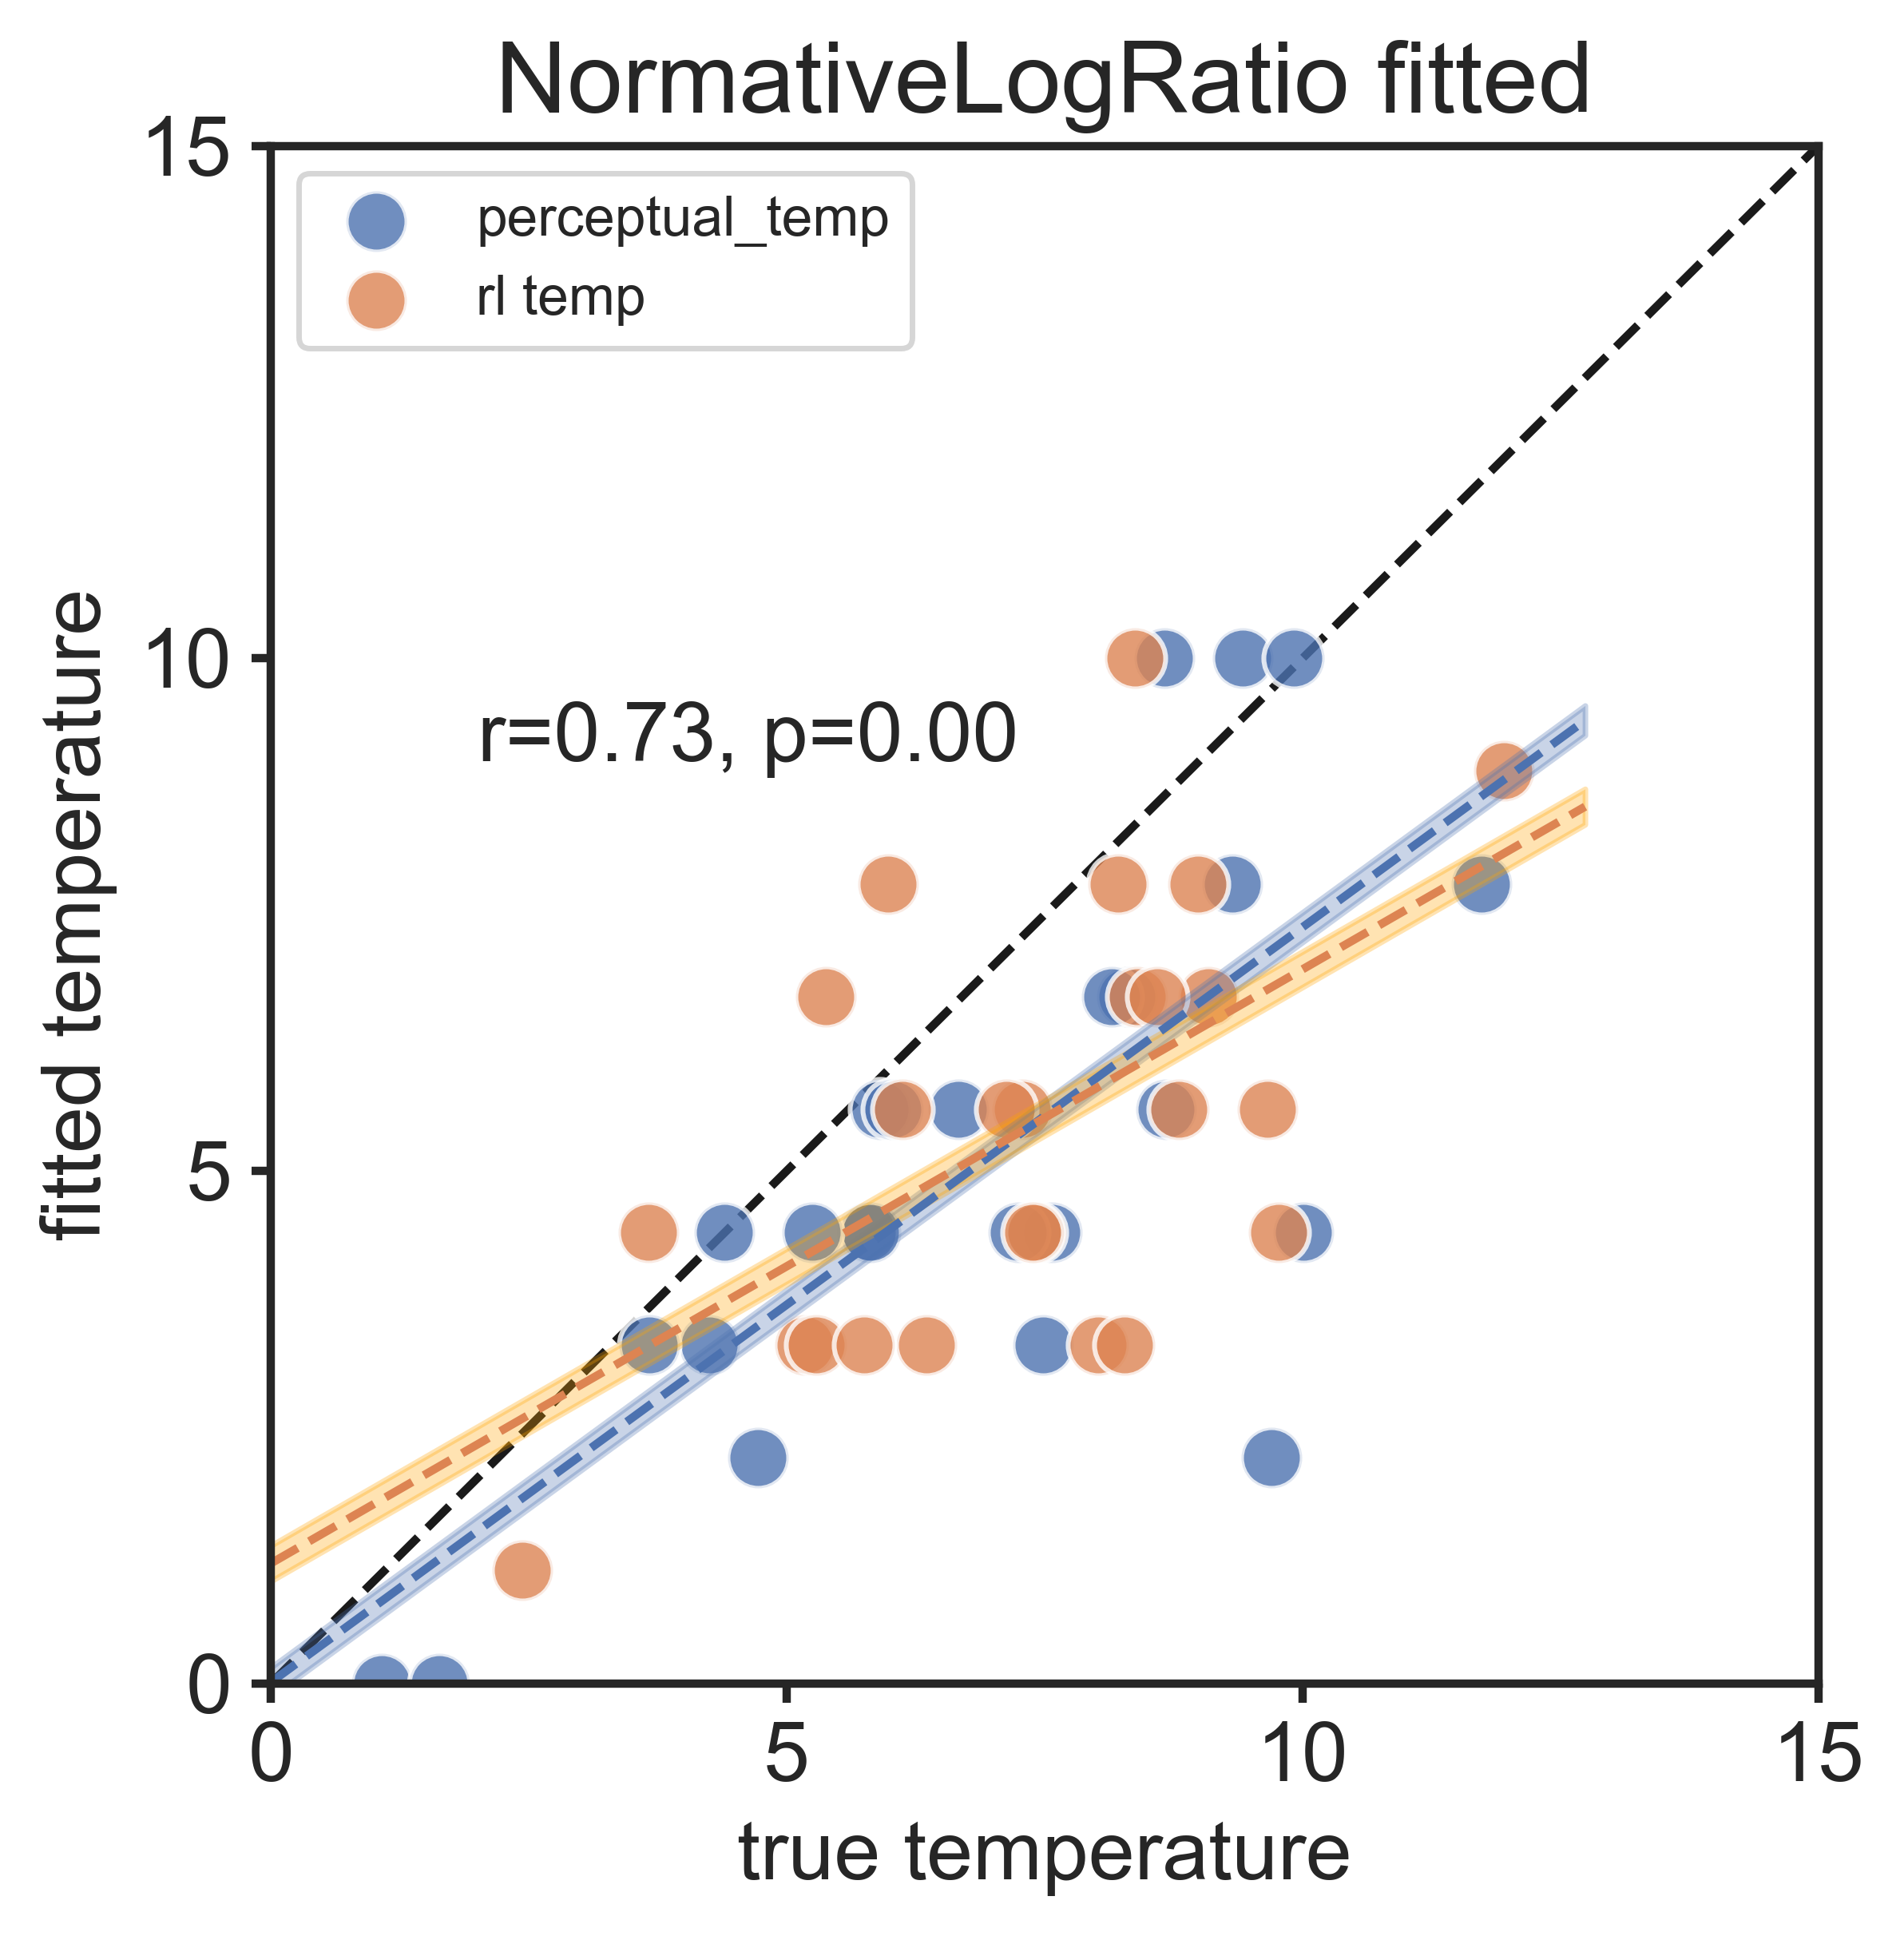

In [ ]:
#same for logratio
plt.figure(figsize=(5, 5), dpi=500)
d2 = d[(d.model=='NormativeLogRatio') & (d.original_model=='NormativeLogRatio')]
sns.scatterplot(x='perceptual_temp', y='fitted_perceptual_temp', data=d2, s=120, alpha=.8, label='perceptual_temp')
sns.scatterplot(x='rl_temp', y='fitted_rl_temp', data=d2, s=120, alpha=.8, label='rl temp')
# plot identity line by finding min and max + 1
max_ = max(d2['perceptual_temp'].max(), d2['fitted_perceptual_temp'].max()) + 1
plt.plot([0, 15], [0, 15], color='k', linestyle='--', zorder=-1)
plt.legend()
plt.title('NormativeLogRatio fitted')
plt.xlabel('true temperature')
plt.ylabel('fitted temperature')
plt.ylim([0, 15])
plt.xlim([0, 15])
# put same yticls and xticks labels
plt.yticks(np.arange(0, 16, 5))
plt.xticks(np.arange(0, 16, 5))

# add linear regression, confidence interval and pearson r
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(d2['perceptual_temp'], d2['fitted_perceptual_temp'])
plt.plot([0, max_], [intercept, max_*slope+intercept], color='C0', linestyle='--')
# plot confidence interval
plt.fill_between([0, max_], [intercept-std_err, max_*slope+intercept-std_err], [intercept+std_err, max_*slope+intercept+std_err], alpha=.3, color='b')

# same for rl temp
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(d2['rl_temp'], d2['fitted_rl_temp'])
plt.plot([0, max_], [intercept, max_*slope+intercept], color='C1', linestyle='--')
# plot confidence interval
plt.fill_between([0, max_], [intercept-std_err, max_*slope+intercept-std_err], [intercept+std_err, max_*slope+intercept+std_err], alpha=.3, color='orange')

# pearson r
from scipy.stats import pearsonr
r, p = pearsonr(d2['perceptual_temp'].dropna(), d2['fitted_perceptual_temp'].dropna())
plt.text(2, 9, f'r={r:.2f}, p={p:.2f}', fontdict={'fontsize': 15})


# plot identity
# plt.plot([0, 10], [0, 15], color='k', linestyle='--')

In [ ]:
# data frame to store the results
dfsim = []
# define progress bar
pbar = tqdm(total=nagents*len(models))

# model parameters
normative_param1 = dict(delta_prior=.2, slope_prior=true_slope, temp=10, x=ff_values, leak=0)
normative_param2 = dict(delta_prior=.2, slope_prior=true_slope, rl_temp=1e2, perceptual_temp=1e4, 
x=ff_values, leak=0)

hybrid_param = dict(perceptual_temp=1e6, perceptual_model='logit', x=ff_values,
    lr=.5, rl_temp=1e6, n_states=2, n_actions=2, q0=np.mean(blocks))

params = (normative_param1, normative_param2, {})
models = (NormativeEV, NormativeLogRatio, RandomModel)

# -----------------------------------------------------------------
# RUN
# -----------------------------------------------------------------
agent_id = 0
for agent in range(nagents):
    for model, param in zip(models, params):
        
        d = d[d.agent==agent]

        p_temp = d.fitted_perceptual_temp.values[0]
        rl_temp = d.fitted_rl_temp.values[0]
        temp = d.fitted_temp.values[0]

        param.update({'perceptual_temp': p_temp, 'rl_temp': rl_temp})
        param.update({'temp': temp})
        
        m = model(**param)

        df2 = df[df.agent==agent]
        s = df2.s.values
        ff1, ff2, ffp1, ffp2 = \
            df2.ff1.values, df2.ff2.values, df2.ffp1.values, df2.ffp2.values
        ntrials = df2.trial.max()

        for t in range(ntrials):
            
            # state = s = block index
            s = block_idx[t]

            # make choice
            a = m.make_choice(s, ff1[t], ff2[t])
            
            ffp_chosen = [ffp1[t], ffp2[t]][a]
            ffp_unchosen = [ffp1[t], ffp2[t]][1-a]

            ff_chosen = [ff1[t], ff2[t]][a]
            ff_unchosen = [ff1[t], ff2[t]][1-a]
            
            destroy = np.random.random() < ffp_chosen
            
            m.learn_perceptual(ff_chosen, destroy)

            r = 0
            
            if destroy:
                r = tnormrdn(blocks[s][a], std)
                m.learn_value(s, a, r)
                
            optimal_option = a==0
            optimal_ev = (ffp_chosen*blocks[s][a])  > (ffp_unchosen*blocks[s][1-a])
            optimal_ff = ffp_chosen >= ffp_unchosen

            cumulative_reward += r

            dfsim.append(
                {
                    'temp': param.get('temp'),
                    'perceptual_temp': param.get('perceptual_temp'),
                    'rl_temp': param.get('rl_temp'),
                    'ff1': ff1[t],
                    'ff2': ff2[t],
                    'ffp1': ffp1[t],
                    'ffp2': ffp2[t],
                    'trial': t,
                    'model': str(model.__name__),
                    'agent': agent_id,
                    's': s,
                    'a': a,
                    'r': r,
                    'optimal_option': optimal_option,
                    'optimal_ev': optimal_ev,
                    'optimal_ff': optimal_ff,
                    'choice': ff[a],
                    'params': m.get_params(s=s),
                    'destroy': destroy,
                    'cumulative_reward': cumulative_reward
                }
            )
            
        pbar.update()

dfsim = pd.DataFrame(dfsim)
# unpack parameters
# tqdm.pandas()

# refresh progress bar
pbar.refresh()
print('done')

In [ ]:
# example of using scipy.optimize.minimize
import numpy as np
from scipy.optimize import minimize

def rosen(x, *args):
    """The Rosenbrock function"""
    print(args)
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
args = (1, 2, 3, 4)
res = minimize(rosen, x0, args=args, method='BFGS', options={'disp': True})

In [ ]:
sns.set({'figure.figsize': (12, 8)})
sns.set_style('ticks')

plt.subplot(1, 2, 1)
# plot dotted line at .5
plt.plot([0, 2], [.5, .5], color='grey', linestyle=':')
avg = df.groupby(['agent', 'model'], as_index=False).mean()
new_df = pd.DataFrame({'score': np.array([avg['optimal_option'], avg['optimal_ff'], avg['optimal_ev']]).flatten(), 'type': np.array(
    ['option',] * len(avg['optimal_option'])
    + ['forcefield',] * len(avg['optimal_ff'])
    + ['forcefield * option',] * len(avg['optimal_ev'])).flatten(),
    'model':np.array([avg['model'], avg['model'], avg['model']]).flatten()})

# replace barplot by distplot with dots
ax = sns.barplot(x='type', y='score', data=new_df,alpha=.5, zorder=0, hue='model', dodge=True)
plt.legend([],[], frameon=False)
sns.stripplot(x='type', y='score', data=new_df, hue='model', jitter=True, alpha=.8, size=8, zorder=1, dodge=True)
plt.ylabel('p(optimal)')
plt.xlabel('var')
plt.xticks([0, 1, 2], ['option', 'forcefield', 'forcefield * option'])
plt.ylim(0, 1)


plt.subplot(1,2, 2)
# plot dotted line at .5
# plt.plot([0, 2], [.5, .5], color='grey', linestyle=':')

last_trial = df[df['trial'] == df['trial'].max()]

ax = sns.barplot(x='model', y='cumulative_reward', data=last_trial, alpha=.5, zorder=0, width=.5)
sns.stripplot(x='model', y='cumulative_reward', data=last_trial, hue='model', jitter=.2, alpha=.8, size=8, zorder=1)
plt.show()

import pingouin as pg
pg.ttest(df[df['model'] == 'LogitRLEV']['cumulative_reward'], df[df['model'] == 'NormativeEV']['cumulative_reward'])



In [ ]:
sns.set({'figure.figsize': (18, 8)})
sns.set_style('ticks')

plt.subplot(2, 3, 1)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_rl', hue='model', data=df)
plt.ylabel('p(choose best option)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 2)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_ff', data=df)
plt.ylabel('p(choose best forcefield)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 4)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_full', data=df)
plt.ylabel('p(choose best forcefield + option)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 5)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='choice', data=df)
plt.ylabel('choice (option A = 0 ; option B = 1)')
plt.ylim(0, 1 )

plt.subplot(1, 3, 3)
# plot dotted line at .5
plt.plot([0, 3], [.5, .5], color='grey', linestyle=':')
avg = df.groupby('agent').mean()
# 1s column = score, 2nd colum type ('rl', 'ff', 'full')
new_df = pd.DataFrame({'score': np.array([avg['correct_rl'], avg['correct_ff'], avg['correct_full']]).flatten(), 'type': np.array(
    ['option',] * len(avg['correct_rl'])
    + ['forcefield',] * len(avg['correct_ff'])
    + ['forcefield + option',] * len(avg['correct_full'])).flatten()})

sns.barplot(x='type', y='score', data=new_df,alpha=.5, zorder=0)
sns.stripplot(x='type', y='score', data=new_df, hue='type', jitter=.2, alpha=.8, size=8, zorder=1)
plt.ylabel('p(choose best var)')
plt.xlabel('var')
plt.xticks([0,1,2], ['option', 'forcefield', 'forcefield + option'])
plt.ylim(0,1)



In [ ]:
#plot the distribution of model parameters
sns.set({'figure.figsize':(11,8)})
sns.set_style('ticks')

params = pd.DataFrame(
    {
        'param': np.array(
            ['lr', ] * nagents
          + ['rl_temp', ] * nagents
          + ['perceptual_temp', ] * nagents
        ).flatten(),
        'value': np.array(
            [agent.lr for agent in agents]
          + [agent.rl_temp for agent in agents]
          + [agent.perceptual_temp for agent in agents]
        ).flatten(),
    }
)

fig, ax = plt.subplots(ncols=2, nrows=1)
print(ax)

sns.displot(
    data=params,
    x='value',
    hue='param',
    kind='kde',
    fill=True,
    palette='colorblind',
    # split distributions  into 3 layers
    # (one for each parameter)
    # to make the plot more readable
    ax=ax[0]
    
)

d = df.groupby(['agent'], as_index=False).mean()
d.drop(['trial', 'choice', 'chosen_ff', 'unchosen', 'unchosen_ff', 'agent'], axis=1, inplace=True)
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax[1])


In [ ]:
# fig config
plt.rcParams['figure.figsize'] = [8, 5]
#  axes width * 1.5 
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

sns.set_style('ticks')

if 'params' in df.columns:
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        df = pd.concat([df.drop(['params'], axis=1), df['params'].apply(pd.Series)], axis=1)

# plot evolution of parameters for each model
plt.figure()
sns.lineplot(x='trial', y='β', data=df[df['model']=='NormativeEV'], label='β', n_boot=0, errorbar='se')
# plot true slope
plt.plot([0, ntrials], [true_slope, true_slope], '--', color='k', label='true slope')
sns.despine(trim=True)

plt.figure()
mask = df.model == 'LogitRLEV'
sns.lineplot(x='trial', y='β', data=df[mask], label='β', n_boot=0, errorbar='se')
sns.lineplot(x='trial', y='α', data=df[mask], label='α', n_boot=0, errorbar='se')
# plot true slope
plt.plot([0, ntrials], [true_slope, true_slope], '--', color='k', label='true slope')
plt.ylabel(('value'))
sns.despine(trim=True)
plt.figure()
sns.lineplot(x='trial', y='σ', data=df[df.model=='NormativeEV'], label='σ', n_boot=0, errorbar='se')
# plot true delta (.2 & .4)
sns.lineplot(x=[0, ntrials], y=[blocks[0][0] - blocks[0][1]] * 2, ls='--', color='r', label='true σ (block 1)')
sns.lineplot(x=[0, ntrials], y=[blocks[1][0] - blocks[1][1]] * 2, ls='--', color='g', label='true σ (block 2)')
sns.despine(trim=True)